# Part 1
Calculate time gaps between inputs

In [3]:
import sqlite3
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time as t
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tabulate import tabulate

def encode_OHE(df):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df)

    new_feats = encoder.transform(df)
    new_cols = pd.DataFrame(new_feats, dtype=int)
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop('id', axis=1, inplace=True)
    return new_df

def binary_search(arr, x, isStart):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        if arr.iloc[mid] < x:
            low = mid + 1
        elif arr.iloc[mid] > x:
            high = mid - 1
        else:
            return mid
    
    return mid + 1

def transform_wrong_distractions(recorded_images):
    for i in range(len(recorded_images)-1):
        current_rec = recorded_images.iloc[i]
        next_rec = recorded_images.iloc[i+1]
        delta = round((next_rec["dateTime"] - current_rec["dateTime"]).total_seconds(), 3)
        
        state_condition = (next_rec["state"] == "Inconsistent") or (next_rec["state"] == "Distracted")
        time_condition = delta < 6.0
        if (current_rec["state"] == "Present") and state_condition and time_condition:
            recorded_images.at[i+1, "state"] = "Present"
    return recorded_images

def find_delta(dictionary):
    current = None
    previous = None
    gaps = {}

    for value in dictionary.values():
        for i in range(0, len(value) - 1):
            if i == 0 and previous == None:
                previous = value[i]['dateTime']
            else:    
                current = value[i]['dateTime']
                previous = value[i - 1]['dateTime']
                delta = round((current - previous).total_seconds(), 3)
                if delta < 3600:
                    if delta in gaps:
                        gaps[delta] += 1
                    else:
                        gaps[delta] = 1
    return gaps

def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta

def filter_present(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Present", dictionary.items()))

def filter_distracted(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Distracted", dictionary.items()))

def filter_absent(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Absent", dictionary.items()))

def filter_inconsistent(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] == "Inconsistent", dictionary.items()))

def filter_non_present(dictionary, recorded_images):
    return dict(filter(lambda element: recorded_images.iloc[element[0]]['state'] != "Present", dictionary.items()))

def filter_non_empty(dictionary):
    return dict(filter(lambda element: len(element[1]) != 0, dictionary.items()))

def filter_empty(dictionary):
    return dict(filter(lambda element: len(element[1]) == 0, dictionary.items()))

def get_data(id, number_check):
    con = sqlite3.connect(id)
    
    cur = con.cursor()
    input_signals = []
    recorded_images = []
    matched = []
    
    input_signals = pd.read_sql('SELECT * FROM signals;', con)
    input_signals['dateTime']= pd.to_datetime(input_signals['dateTime'])
    
    recorded_images = pd.read_sql('SELECT id, dateTime, state FROM images;', con)
    recorded_images['dateTime']= pd.to_datetime(recorded_images['dateTime'])
    
    recorded_images = transform_wrong_distractions(recorded_images)
    con.close()
    

    results = {}
    current = recorded_images.iloc[0]['dateTime']
    next_rec = recorded_images.iloc[1]['dateTime']
    
    input_signals = input_signals.sort_values('dateTime')

    for i in range(0, len(recorded_images) - 2):
        fromIndex = binary_search(input_signals['dateTime'], current, True)
        toIndex = binary_search(input_signals['dateTime'], next_rec, False)
        if fromIndex == input_signals.shape[0]:
            fromIndex = fromIndex-1
        results[recorded_images['id'].iloc[i]] = [input_signals.iloc[x] for x in range(fromIndex, toIndex)]
        current = next_rec
        next_rec = recorded_images.iloc[i+2]['dateTime']
    
    input_numbers = {
        "Present" : 0,
        "Absent" : 0,
        "Distracted" : 0,
        "Inconsistent" : 0
    }
    for i in range(0, len(recorded_images) - 2):
        input_count = len(results[recorded_images['id'].iloc[i]])
        input_numbers[recorded_images['state'].iloc[i]] += input_count
    
    non_empty = filter_non_empty(results)
    present = filter_present(results, recorded_images)
    distracted = filter_distracted(results, recorded_images)
    absent = filter_absent(results, recorded_images)
    inconsistent = filter_inconsistent(results, recorded_images)
    
    present_and_non_empty = filter_non_empty(present)
    present_and_empty = filter_empty(present)
    
    distracted_and_non_empty = filter_non_empty(distracted)
    distracted_and_empty = filter_empty(distracted)
    
    absent_and_non_empty = filter_non_empty(absent)
    absent_and_empty = filter_empty(absent)
    
    inconsistent_and_non_empty = filter_non_empty(inconsistent)
    inconsistent_and_empty = filter_empty(inconsistent)
    
    print("present with input")
    print(len(present_and_non_empty) * 100 / len(results))
    print("present without input")
    print(len(present_and_empty) * 100 / len(results))
    
    print("distracted with input")
    print(len(distracted_and_non_empty) * 100 / len(results))
    print("distracted without input")
    print(len(distracted_and_empty) * 100 / len(results))
    
    print("absent with input")
    print(len(absent_and_non_empty) * 100 / len(results))
    print("absent without input")
    print(len(absent_and_empty) * 100 / len(results))
    
    print("inconsistent with input")
    print(len(inconsistent_and_non_empty) * 100 / len(results))
    print("inconsistent without input")
    print(len(inconsistent_and_empty) * 100 / len(results))
    
    print("\n")
    percentages = {
        "present_and_with_input" : len(present_and_non_empty) * 100 / len(results),
        "present_and_without_input" : len(present_and_empty) * 100 / len(results),
        "distracted_and_with_input" : len(distracted_and_non_empty) * 100 / len(results),
        "distracted_and_without_input" : len(distracted_and_empty) * 100 / len(results),
        "absent_and_with_input" : len(absent_and_non_empty) * 100 / len(results),
        "absent_and_without_input" : len(absent_and_empty) * 100 / len(results),
        "inconsistent_and_with_input" : len(inconsistent_and_non_empty) * 100 / len(results),
        "inconsistent_and_without_input" : len(inconsistent_and_empty) * 100 / len(results)
    }
    
    answer = [find_delta(non_empty), find_delta(present_and_non_empty), percentages, input_numbers]
    return answer

time_results = {}

average_percentages = {
    "present_and_with_input" : 0,
    "present_and_without_input" : 0,
    "distracted_and_with_input" : 0,
    "distracted_and_without_input" : 0,
    "absent_and_with_input" : 0,
    "absent_and_without_input" : 0,
    "inconsistent_and_with_input" : 0,
    "inconsistent_and_without_input" : 0,
    "count" : 0
}

average_input_numbers = {
    "Present" : 0,
    "Absent" : 0,
    "Distracted" : 0,
    "Inconsistent" : 0,
    "count" : 0
}

states = []
inputs = []



for i in range(1, 31):
    if True:#i!= 16:
        print(i)
        time_results['user'+str(i)] = get_data('user'+str(i)+'.sqlite', i)
        average_percentages["present_and_with_input"] += time_results['user'+str(i)][2]["present_and_with_input"]
        average_percentages["present_and_without_input"] += time_results['user'+str(i)][2]["present_and_without_input"]
        average_percentages["distracted_and_with_input"] += time_results['user'+str(i)][2]["distracted_and_with_input"]
        average_percentages["distracted_and_without_input"] += time_results['user'+str(i)][2]["distracted_and_without_input"]
        average_percentages["absent_and_with_input"] += time_results['user'+str(i)][2]["absent_and_with_input"]
        average_percentages["absent_and_without_input"] += time_results['user'+str(i)][2]["absent_and_without_input"]
        average_percentages["inconsistent_and_with_input"] += time_results['user'+str(i)][2]["inconsistent_and_with_input"]
        average_percentages["inconsistent_and_without_input"] += time_results['user'+str(i)][2]["inconsistent_and_without_input"]
        average_percentages["count"] += 1
        print("input count per category")
        print(time_results['user'+str(i)][3])
        average_input_numbers["Present"] += time_results['user'+str(i)][3]["Present"]
        average_input_numbers["Absent"] += time_results['user'+str(i)][3]["Absent"]
        average_input_numbers["Distracted"] += time_results['user'+str(i)][3]["Distracted"]
        average_input_numbers["Inconsistent"] += time_results['user'+str(i)][3]["Inconsistent"]
        average_input_numbers["count"] += 1

        states.append("Inconsistent")
        inputs.append(time_results['user'+str(i)][3]["Inconsistent"])
        states.append("Absent")
        inputs.append(time_results['user'+str(i)][3]["Absent"])
        states.append("Distracted")
        inputs.append(time_results['user'+str(i)][3]["Distracted"])
        states.append("Present")
        inputs.append(time_results['user'+str(i)][3]["Present"])


print("present_and_with_input")
print(average_percentages["present_and_with_input"] / average_percentages["count"])
print("present_and_without_input")
print(average_percentages["present_and_without_input"] / average_percentages["count"])

print("distracted_and_with_input")
print(average_percentages["distracted_and_with_input"] / average_percentages["count"])
print("distracted_and_without_input")
print(average_percentages["distracted_and_without_input"] / average_percentages["count"])

print("absent_and_with_input")
print(average_percentages["absent_and_with_input"] / average_percentages["count"])
print("absent_and_without_input")
print(average_percentages["absent_and_without_input"] / average_percentages["count"])

print("inconsistent_and_with_input")
print(average_percentages["inconsistent_and_with_input"] / average_percentages["count"])
print("inconsistent_and_without_input")
print(average_percentages["inconsistent_and_without_input"] / average_percentages["count"])

print("average input numbers")
print("Present: ", average_input_numbers["Present"]/average_input_numbers["count"])
print("Absent: ", average_input_numbers["Absent"]/average_input_numbers["count"])
print("Distracted: ", average_input_numbers["Distracted"]/average_input_numbers["count"])
print("Inconsistent: ", average_input_numbers["Inconsistent"]/average_input_numbers["count"])

1
present with input
2.4603174603174605
present without input
70.07936507936508
distracted with input
9.484126984126984
distracted without input
8.253968253968255
absent with input
1.2698412698412698
absent without input
5.912698412698413
inconsistent with input
0.11904761904761904
inconsistent without input
2.4206349206349205


input count per category
{'Present': 328458, 'Absent': 50469, 'Distracted': 102, 'Inconsistent': 0}
2
present with input
35.83617747440273
present without input
15.358361774744028
distracted with input
19.112627986348123
distracted without input
1.3651877133105803
absent with input
9.726962457337883
absent without input
7.337883959044369
inconsistent with input
6.825938566552901
inconsistent without input
4.436860068259386


input count per category
{'Present': 3668, 'Absent': 279, 'Distracted': 107, 'Inconsistent': 160}
3
present with input
10.772442588726513
present without input
56.11691022964509
distracted with input
15.323590814196242
distracted without in

In [5]:
print("Correlation states/inputs")
print("correaltion ratio:", correlation_ratio(np.array(states), np.array(inputs)))

#print("testing similarity")
#print(stats.kruskal([average_input_numbers["Present"]/average_input_numbers["count"]], [average_input_numbers["Absent"]/average_input_numbers["count"]], [average_input_numbers["Distracted"]/average_input_numbers["count"]], [average_input_numbers["Inconsistent"]/average_input_numbers["count"]], nan_policy='omit'))

Correlation states/inputs
correaltion ratio: 0.305574445290755


# Part 2
Visualize data collected

user 1
absent+present


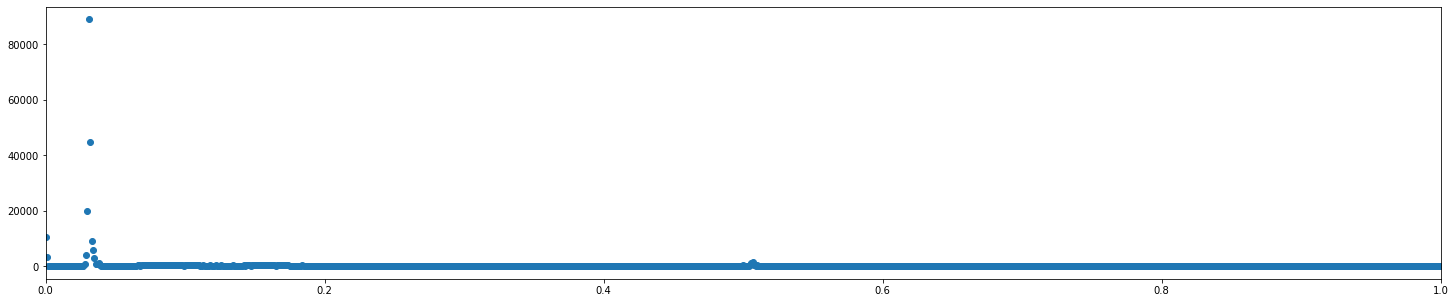

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


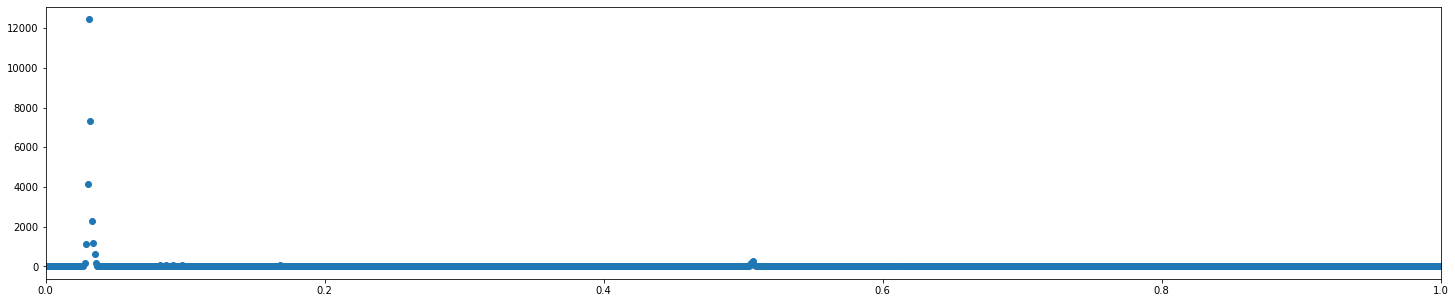

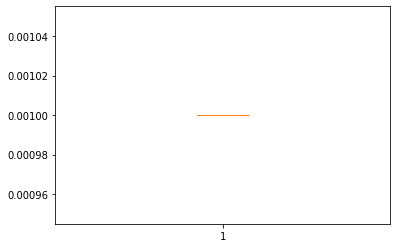

{'nobs': 367667, 'minmax': (0.001, 3066.985), 'mean': 0.8567961252981641, 'variance': 277.3993696807862, 'skewness': 110.61839596021059, 'kurtosis': 14880.254974478145, 'user': 'user1'}
user 2
absent+present


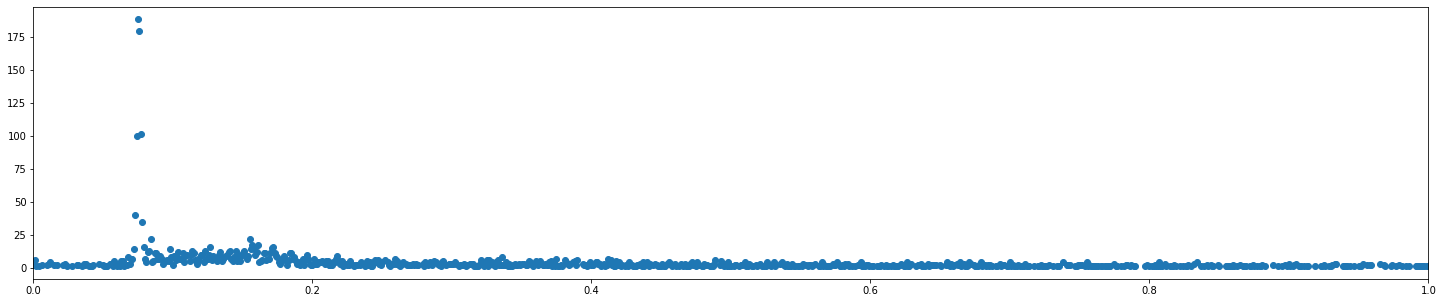

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


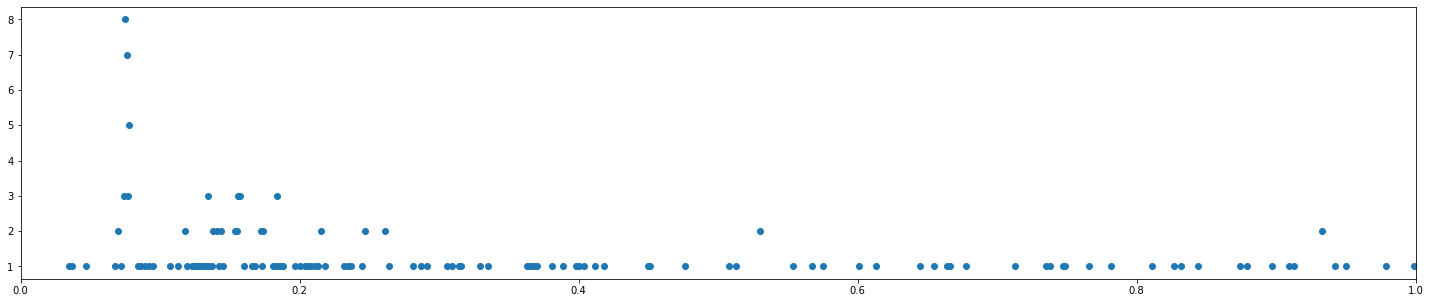

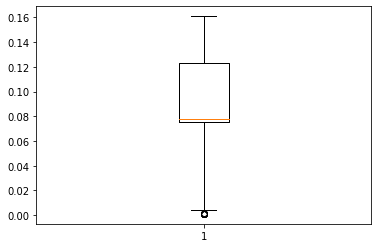

{'nobs': 3635, 'minmax': (0.001, 29.498), 'mean': 0.6614927097661623, 'variance': 2.3028699087938382, 'skewness': 8.910846155385835, 'kurtosis': 118.64463487153506, 'user': 'user2'}
user 3
absent+present


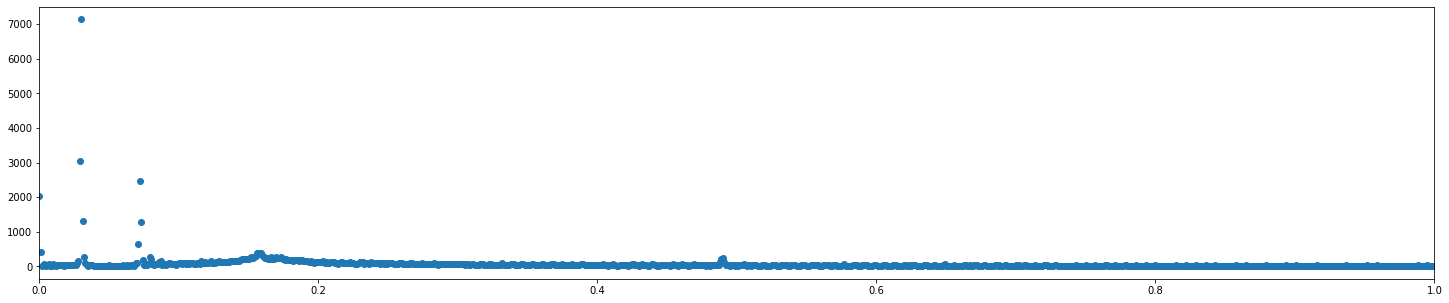

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


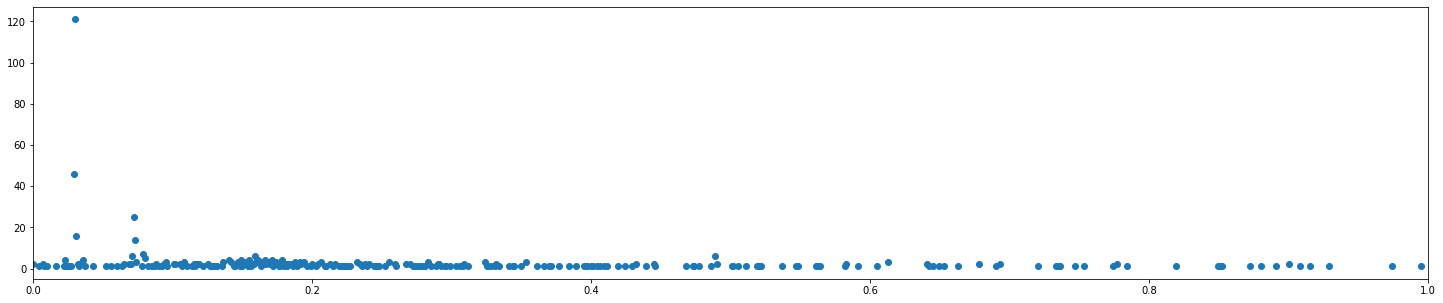

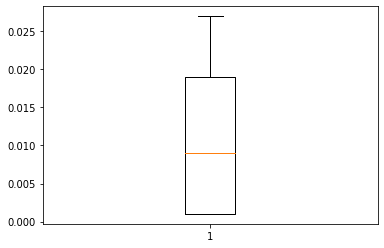

{'nobs': 84508, 'minmax': (0.001, 3109.492), 'mean': 0.9592256709423962, 'variance': 252.20481676104023, 'skewness': 162.04134118632422, 'kurtosis': 29359.018392274495, 'user': 'user3'}
user 4
absent+present


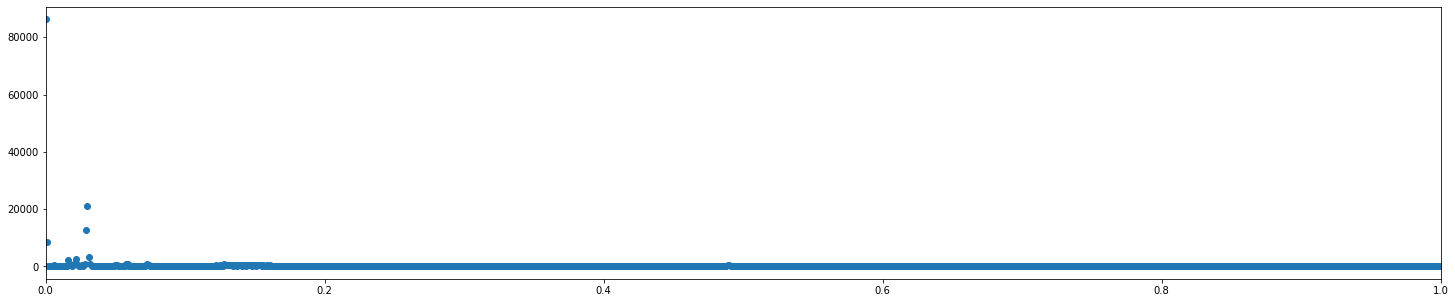

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


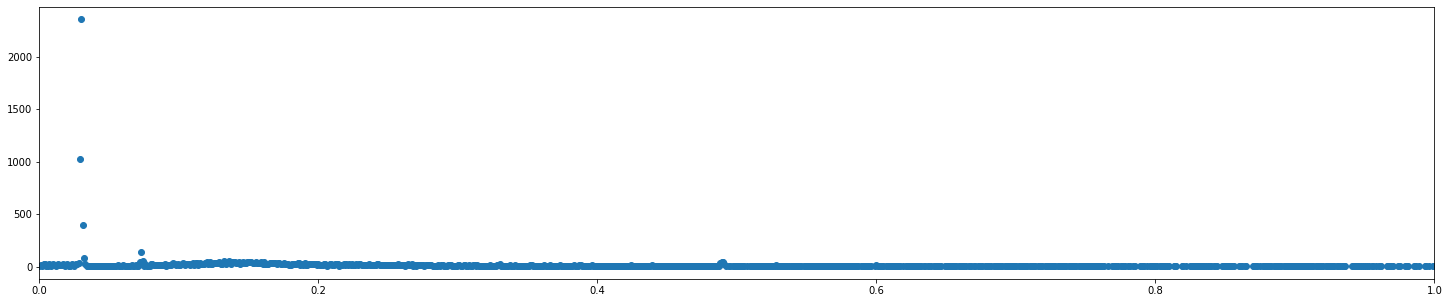

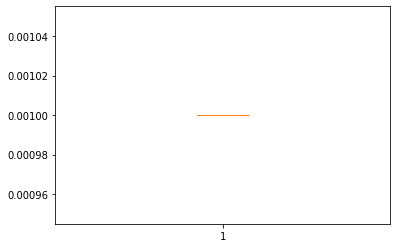

{'nobs': 175672, 'minmax': (0.001, 2697.892), 'mean': 0.5863719488592377, 'variance': 71.82577700965719, 'skewness': 244.011760097225, 'kurtosis': 70415.27697054412, 'user': 'user4'}
user 5
absent+present


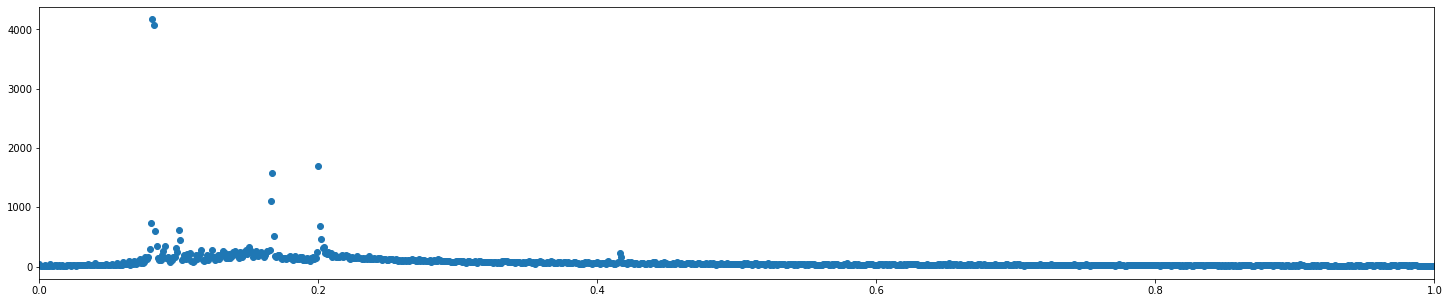

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


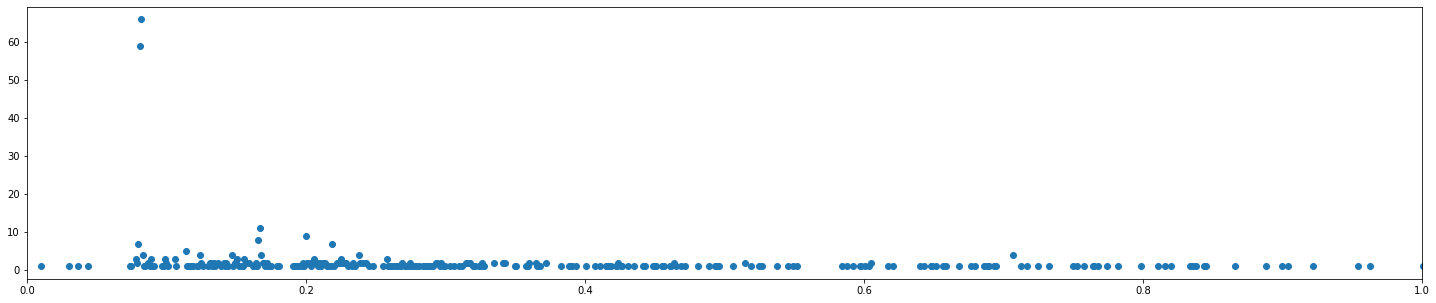

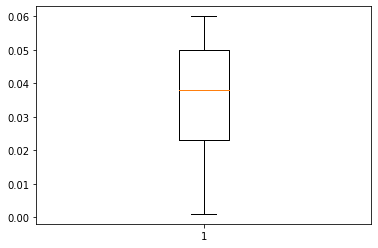

{'nobs': 90997, 'minmax': (0.001, 1497.38), 'mean': 0.7246434497840588, 'variance': 34.07190215808089, 'skewness': 191.08140379335757, 'kurtosis': 47726.751778542624, 'user': 'user5'}
user 6
absent+present


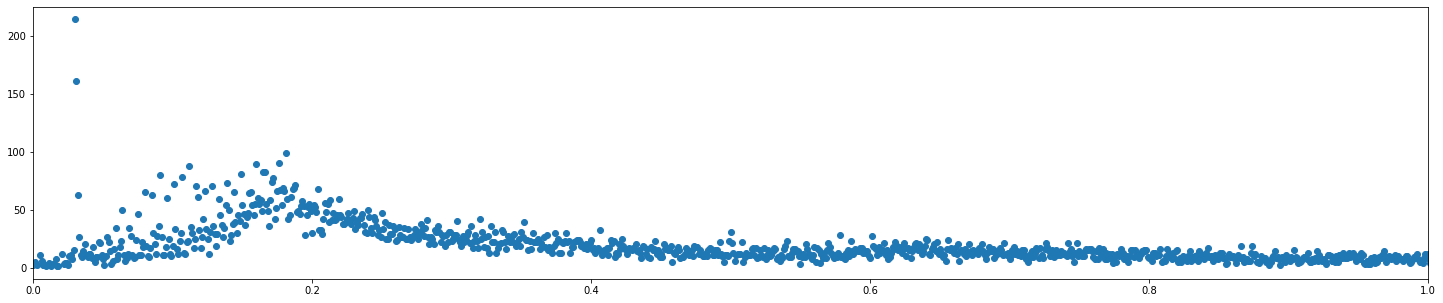

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


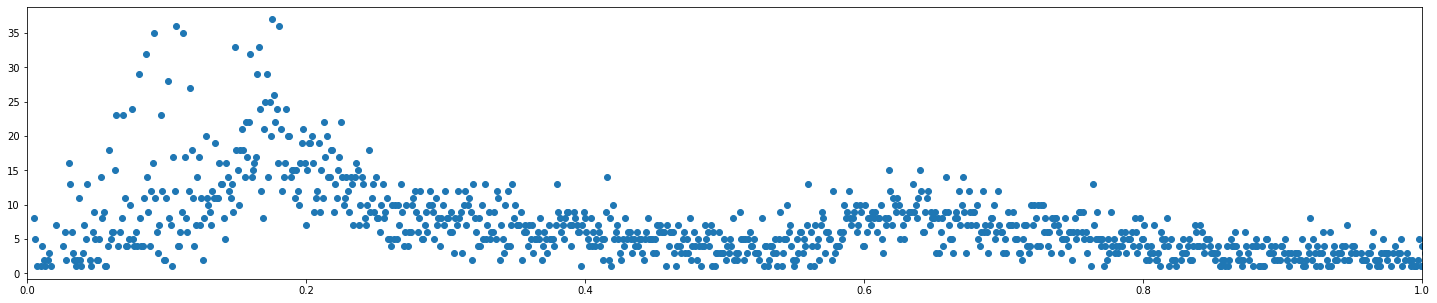

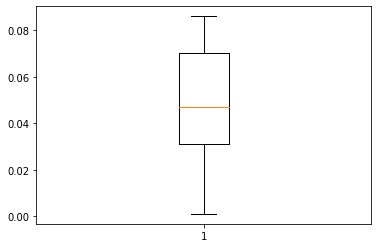

{'nobs': 26760, 'minmax': (0.001, 3089.105), 'mean': 1.3948622944693572, 'variance': 562.638435814999, 'skewness': 112.85050832300466, 'kurtosis': 13536.536028835162, 'user': 'user6'}
user 7
absent+present


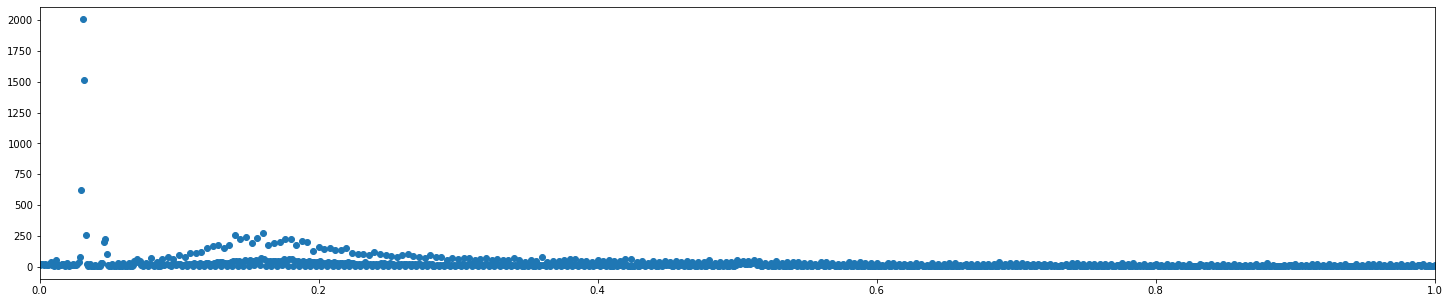

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


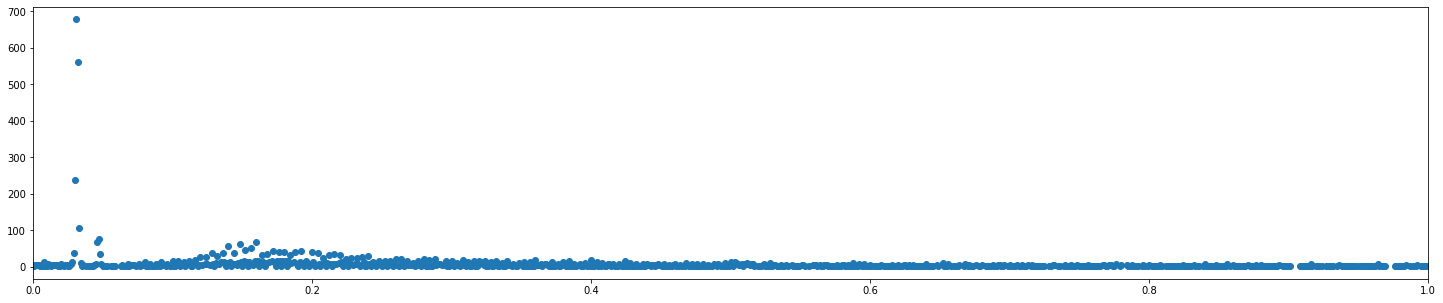

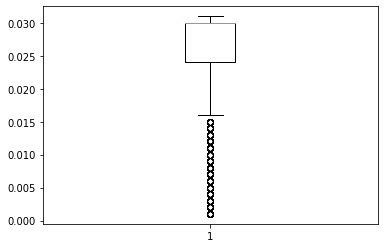

{'nobs': 31237, 'minmax': (0.001, 2609.346), 'mean': 1.279848480968083, 'variance': 663.9091864554955, 'skewness': 74.50766914450638, 'kurtosis': 6325.333194159578, 'user': 'user7'}
user 8
absent+present


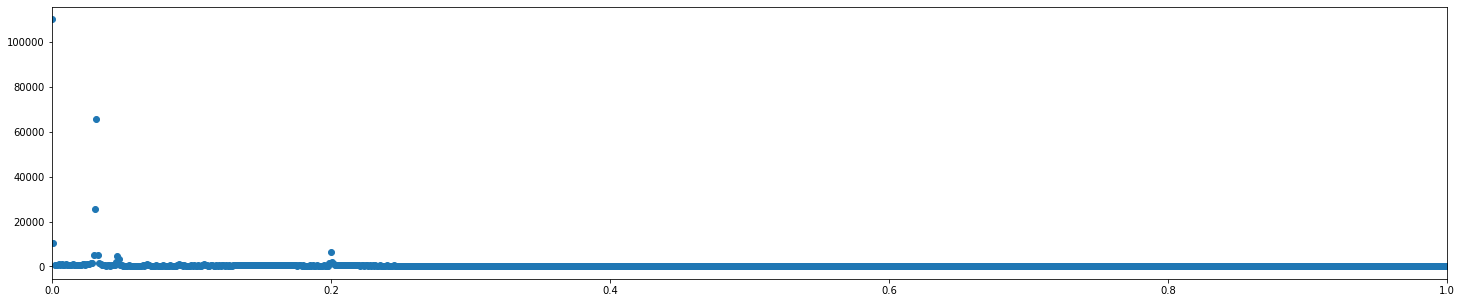

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


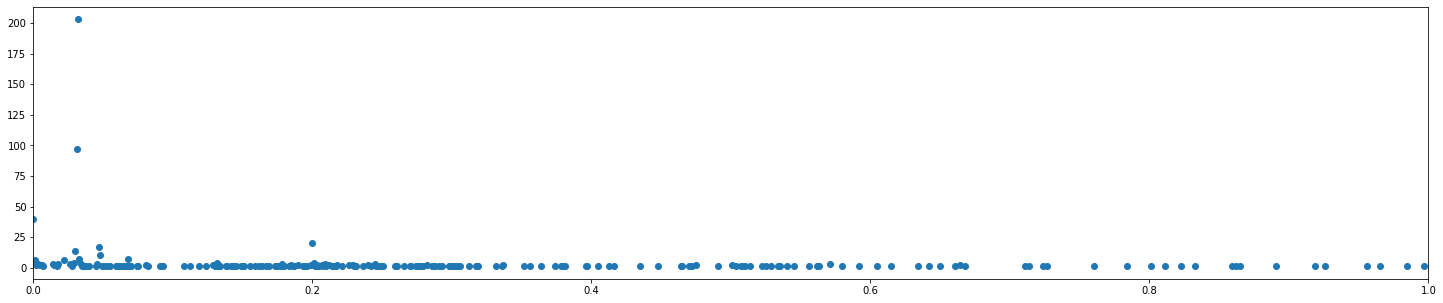

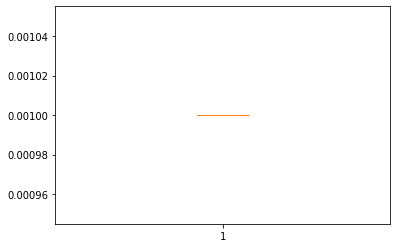

{'nobs': 345871, 'minmax': (0.001, 408.302), 'mean': 0.25774901046922116, 'variance': 3.3028324563552744, 'skewness': 97.8200034112633, 'kurtosis': 14600.845839349362, 'user': 'user8'}
user 9
absent+present


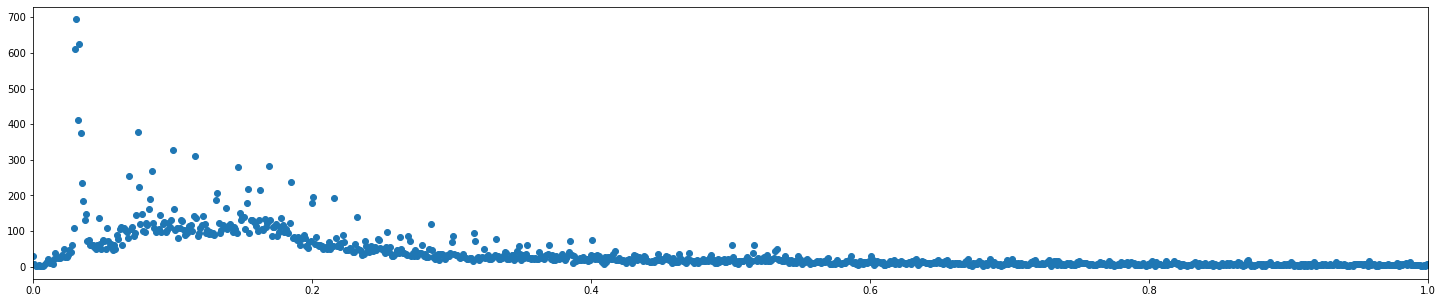

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


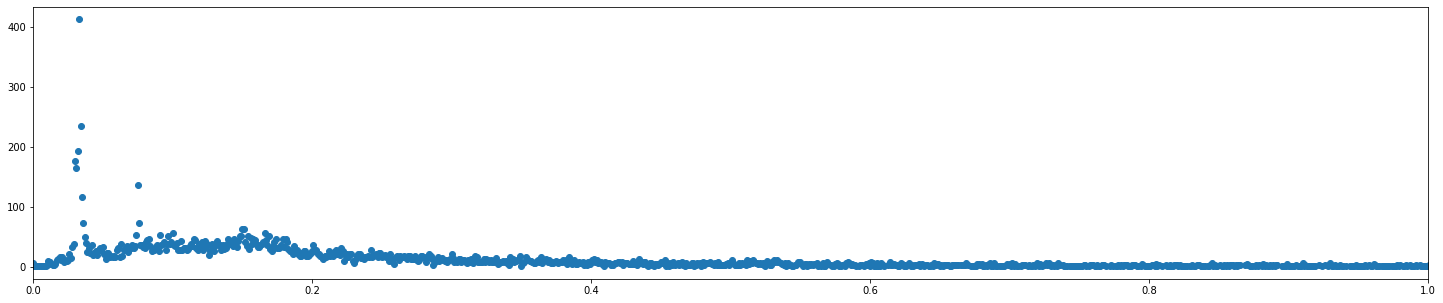

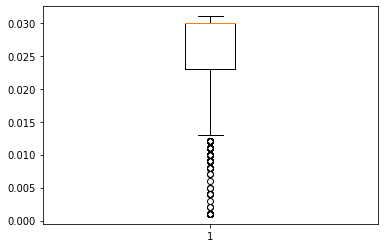

{'nobs': 43995, 'minmax': (0.001, 2888.003), 'mean': 1.1894678486191612, 'variance': 546.4809151379114, 'skewness': 92.16792639200389, 'kurtosis': 9732.486711555799, 'user': 'user9'}
user 10
absent+present


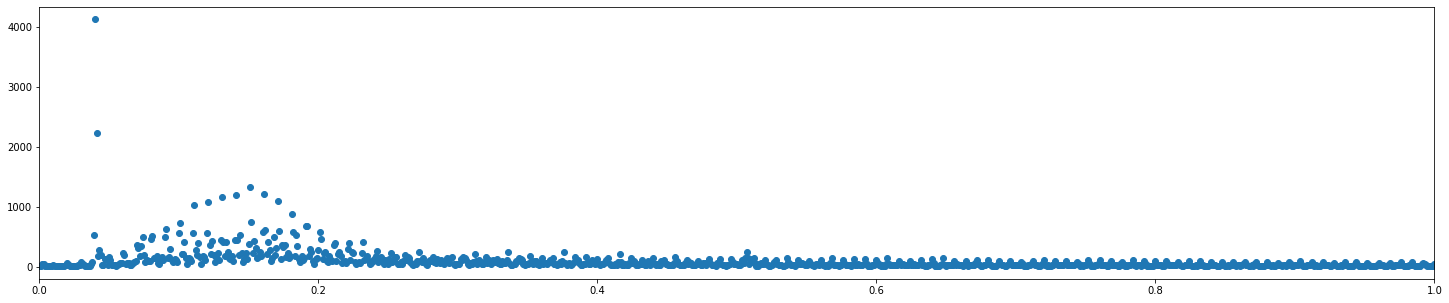

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


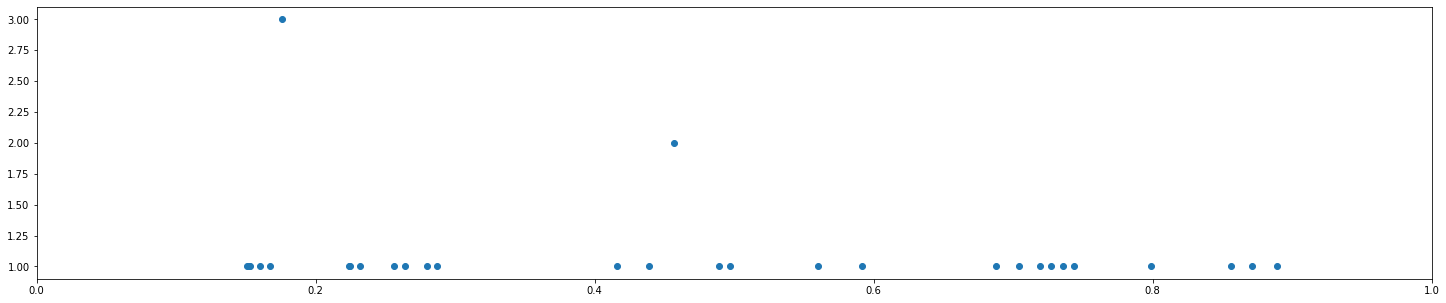

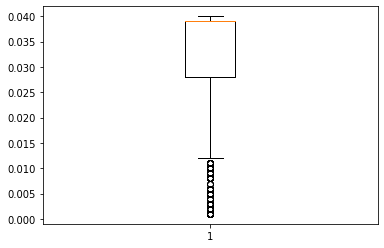

{'nobs': 115907, 'minmax': (0.001, 3239.82), 'mean': 1.4920675369045875, 'variance': 827.9603710710861, 'skewness': 81.8696210219305, 'kurtosis': 7758.52332508132, 'user': 'user10'}
user 11
absent+present


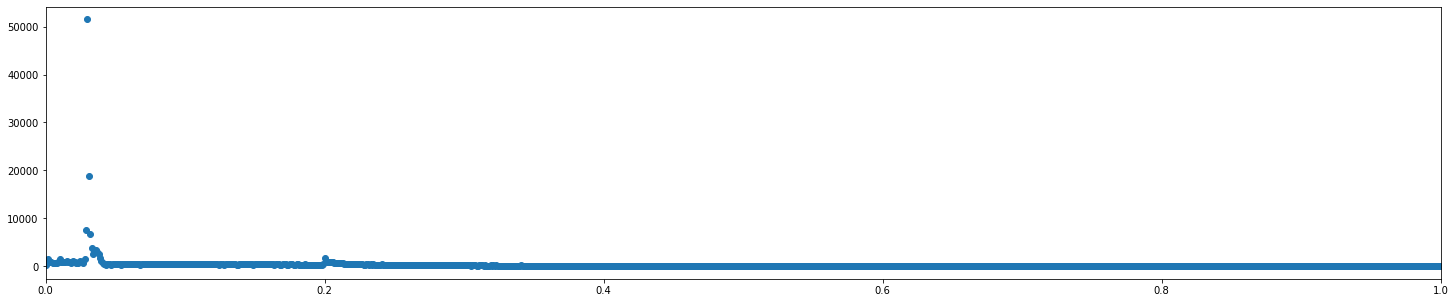

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


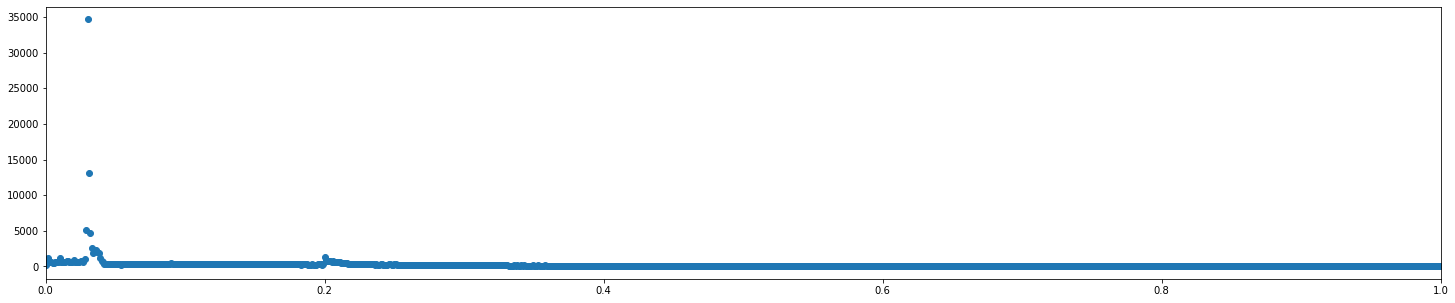

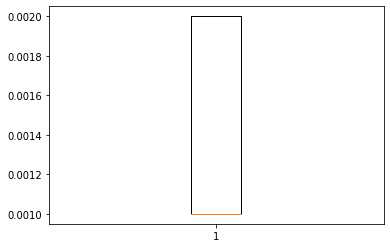

{'nobs': 292125, 'minmax': (0.001, 3577.058), 'mean': 0.3897605750962773, 'variance': 174.0592356149106, 'skewness': 166.40893231020755, 'kurtosis': 34907.32054717698, 'user': 'user11'}
user 12
absent+present
dict_items([(6.183, 1), (1.793, 3), (1.159, 5), (0.105, 34), (3.393, 2), (1.82, 12), (1.805, 11), (0.074, 52), (24.523, 1), (0.518, 26), (1.342, 13), (2.022, 8), (0.188, 134), (89.829, 1), (3.121, 3), (0.144, 132), (1.229, 10), (0.201, 103), (0.405, 40), (0.291, 64), (0.358, 59), (0.155, 148), (0.325, 35), (7.441, 1), (0.88, 15), (1.086, 20), (0.826, 20), (0.446, 51), (4.009, 2), (0.787, 20), (0.532, 27), (0.524, 36), (2.977, 3), (0.748, 33), (0.273, 63), (0.655, 39), (30.654, 1), (0.295, 39), (30.369, 1), (55.195, 1), (5.602, 2), (6.038, 1), (2.111, 2), (2.385, 2), (0.132, 61), (0.278, 82), (0.876, 24), (2.038, 7), (0.25, 102), (0.579, 25), (0.235, 86), (0.299, 62), (0.135, 71), (0.845, 24), (-15.942, 1), (-257.394, 1), (0.703, 28), (116.238, 1), (84.226, 1), (32.313, 1), (14.828

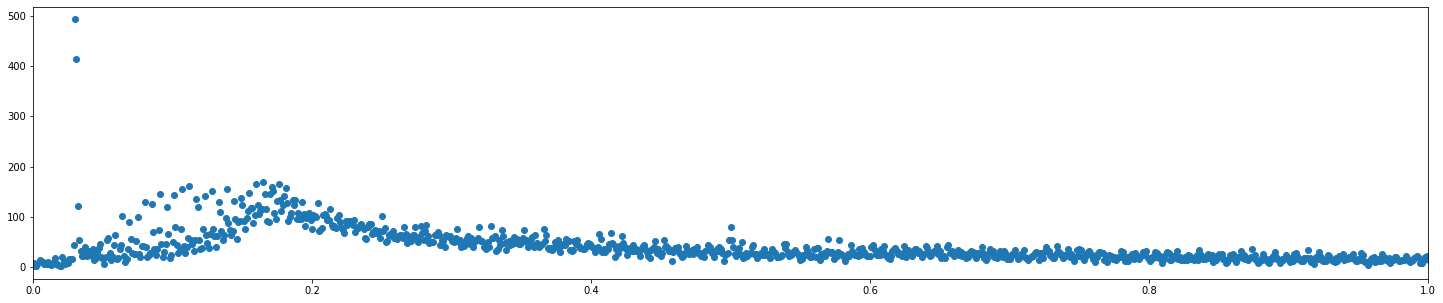

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


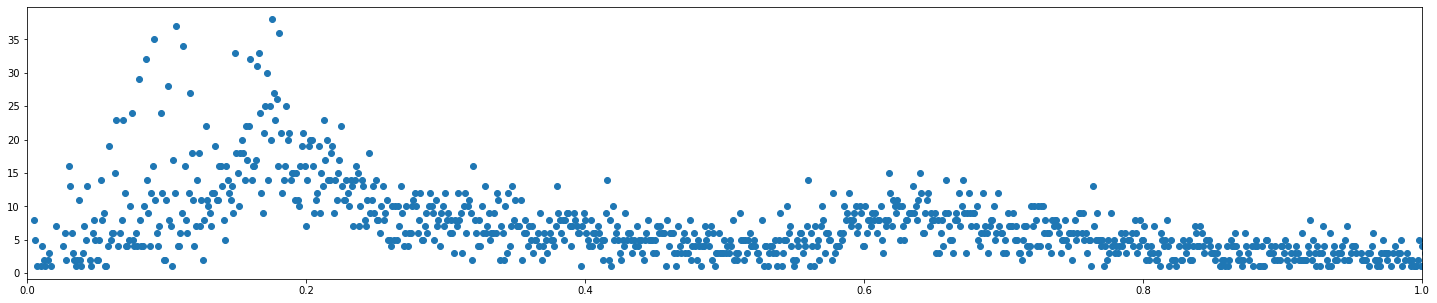

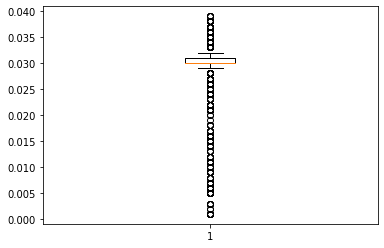

{'nobs': 56272, 'minmax': (0.001, 3089.105), 'mean': 1.4348532840489054, 'variance': 293.686901026154, 'skewness': 143.69729105428993, 'kurtosis': 23660.70089670956, 'user': 'user12'}
user 13
absent+present


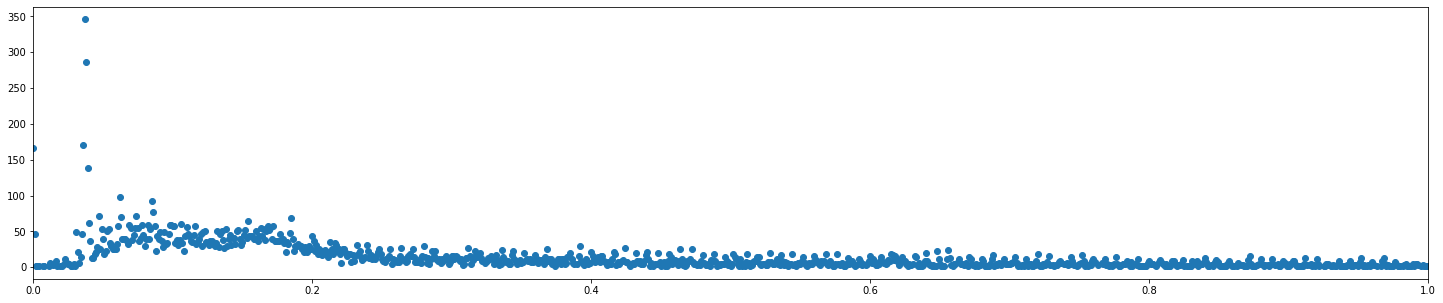

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


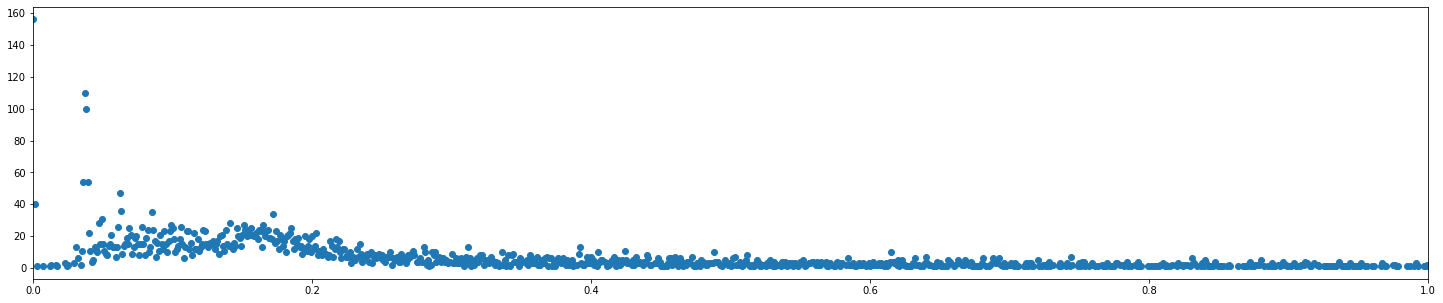

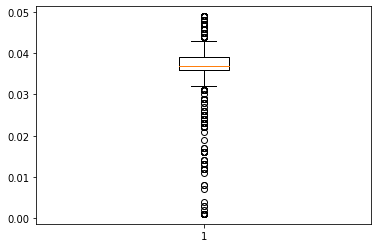

{'nobs': 16909, 'minmax': (0.001, 2632.029), 'mean': 2.610598556981489, 'variance': 1357.490626978058, 'skewness': 40.310139371242954, 'kurtosis': 2117.4752287771726, 'user': 'user13'}
user 14
absent+present


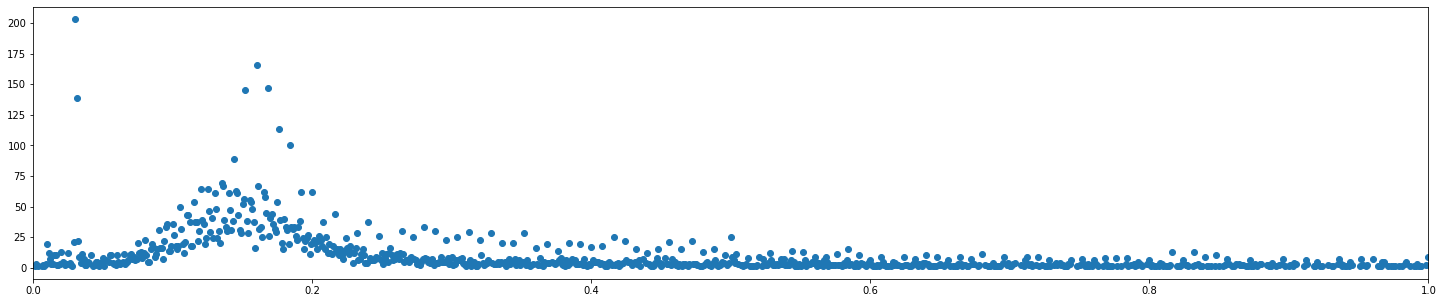

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


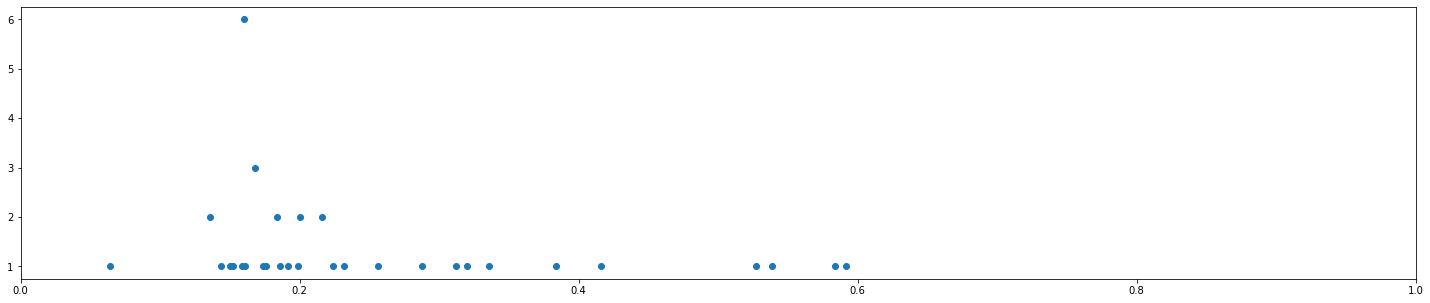

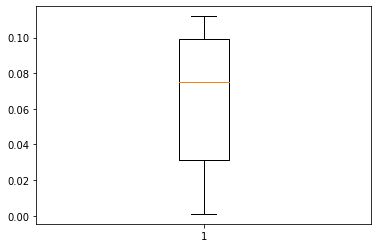

{'nobs': 9421, 'minmax': (0.001, 69.527), 'mean': 0.41514743657785796, 'variance': 1.815846888982016, 'skewness': 33.999704622118884, 'kurtosis': 1545.5990244036675, 'user': 'user14'}
user 15
absent+present


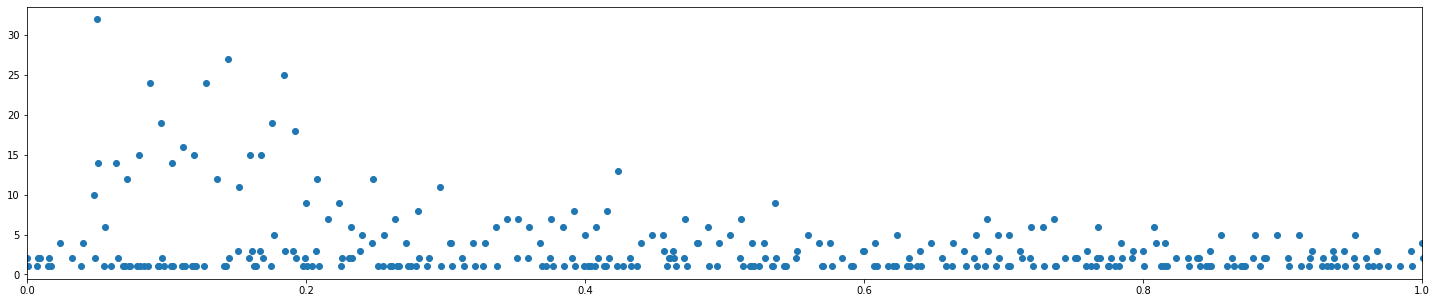

p = 3.41483e-171
The null hypothesis can be rejected
only present
<class 'dict_items'>


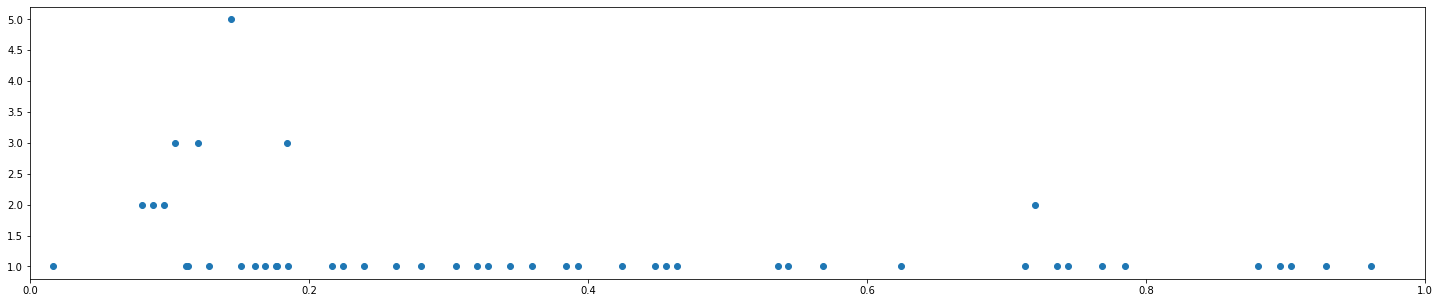

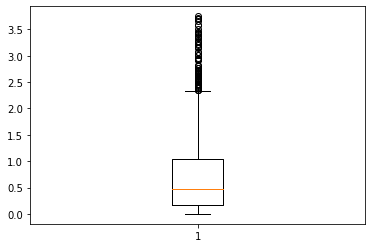

{'nobs': 1529, 'minmax': (0.001, 22.079), 'mean': 0.845018966644866, 'variance': 1.3664222345876746, 'skewness': 6.608697280100886, 'kurtosis': 87.1009825762522, 'user': 'user15'}
user 16
absent+present


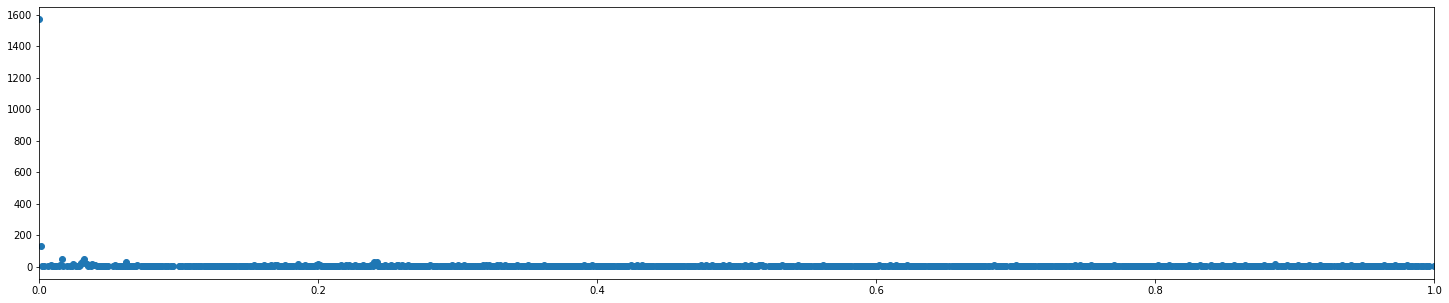

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


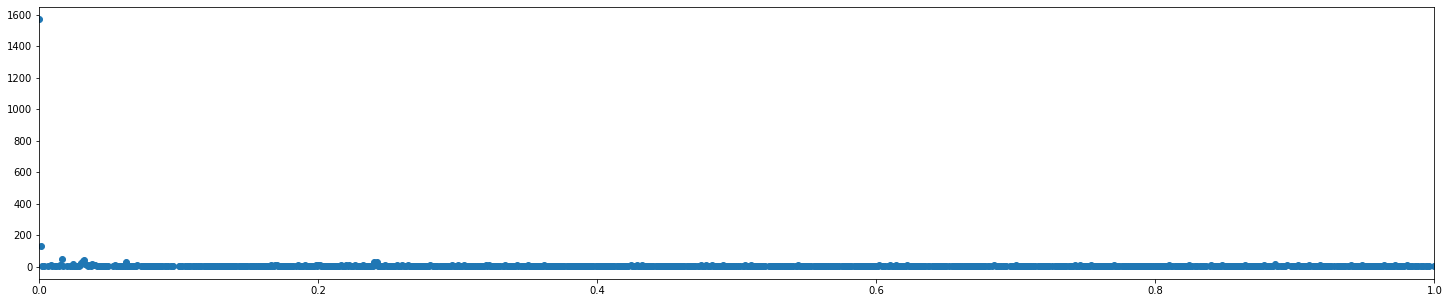

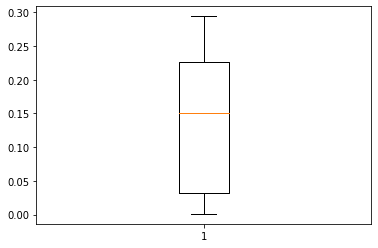

{'nobs': 7082, 'minmax': (0.001, 2988.626), 'mean': 6.767752471053374, 'variance': 5776.592218761062, 'skewness': 24.655059800861373, 'kurtosis': 722.5380378807439, 'user': 'user16'}
user 17
absent+present


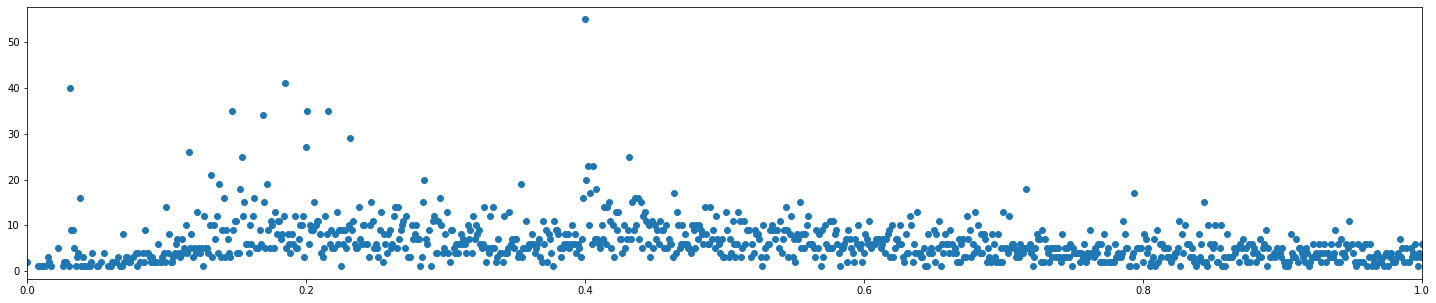

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


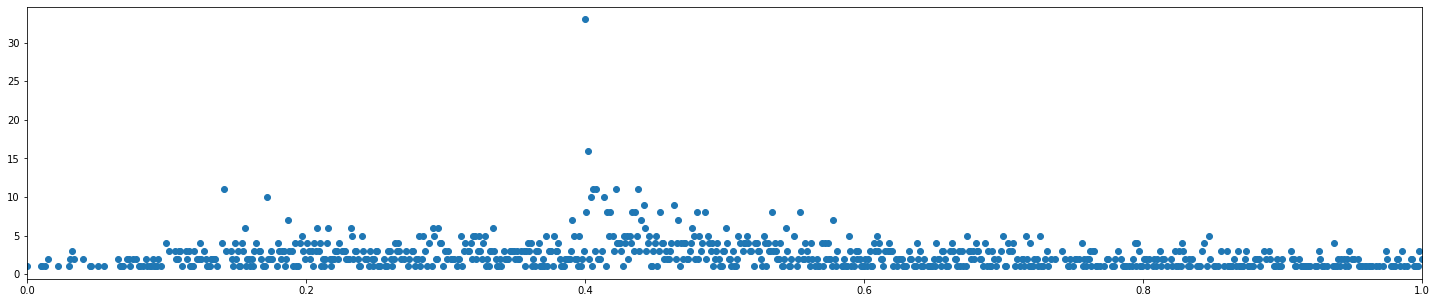

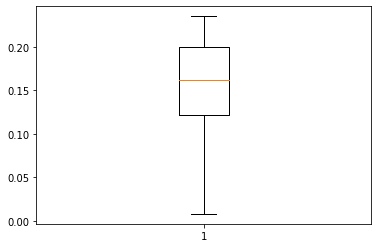

{'nobs': 8814, 'minmax': (0.008, 818.012), 'mean': 1.5719157022918084, 'variance': 179.70286725840995, 'skewness': 46.56766834502097, 'kurtosis': 2427.667699915817, 'user': 'user17'}
user 18
absent+present


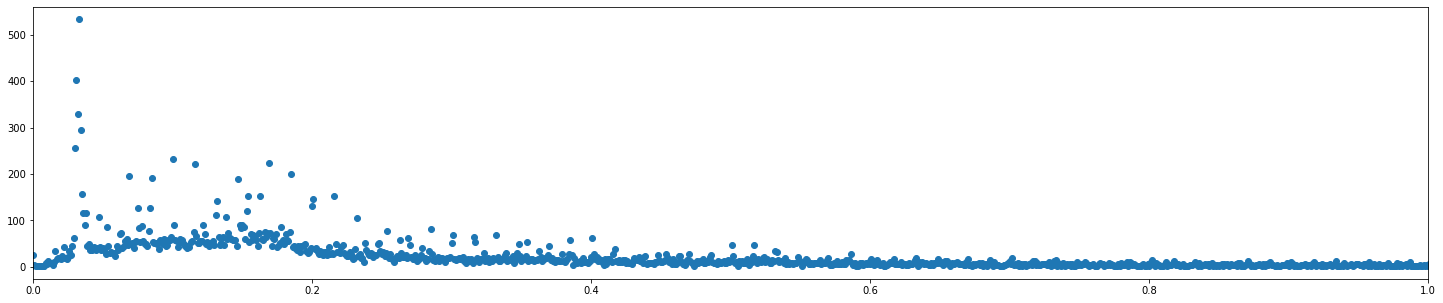

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


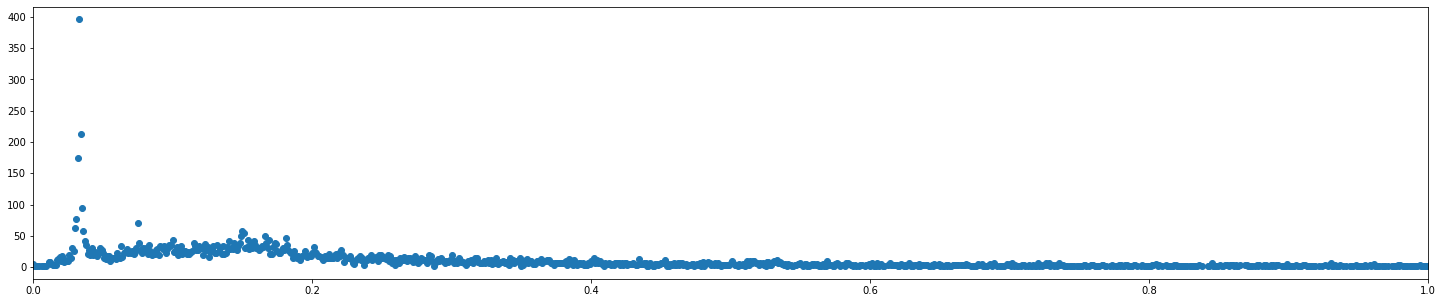

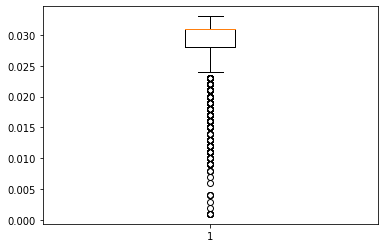

{'nobs': 26717, 'minmax': (0.001, 2485.957), 'mean': 1.375902159673616, 'variance': 455.1556692445067, 'skewness': 84.1574075998316, 'kurtosis': 8670.062989399454, 'user': 'user18'}
user 19
absent+present


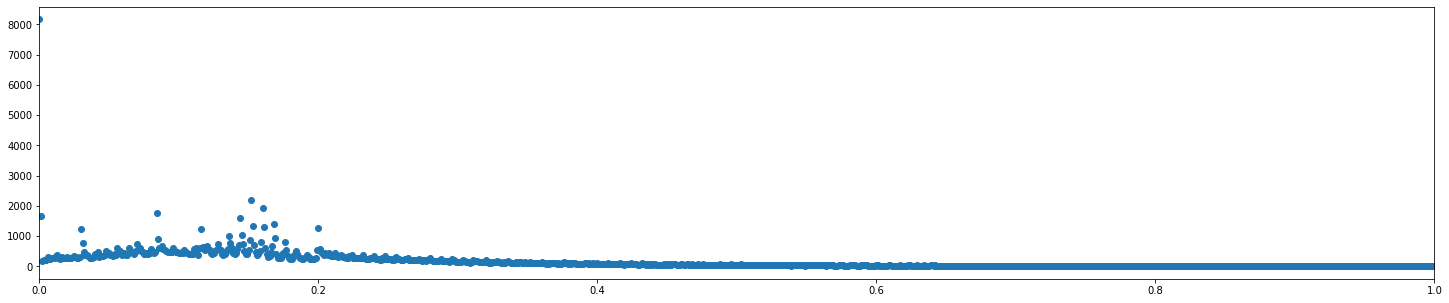

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


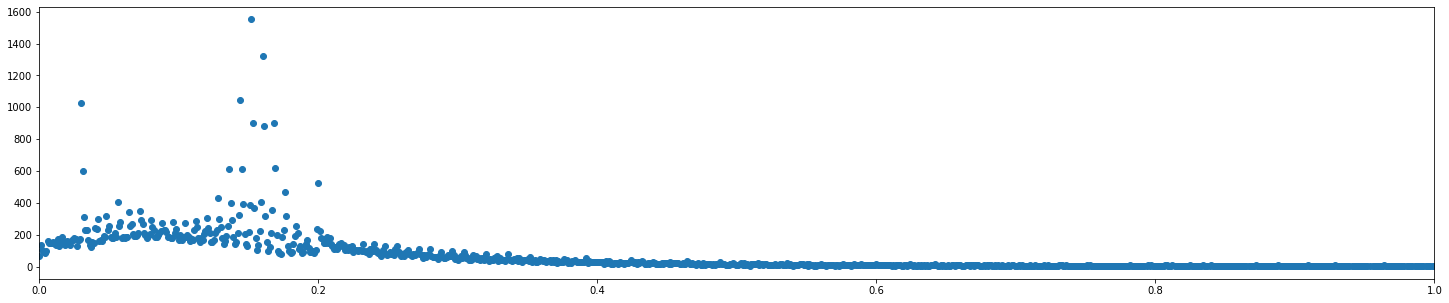

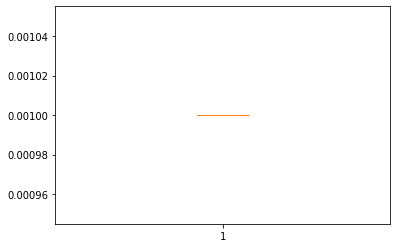

{'nobs': 165300, 'minmax': (0.001, 3057.865), 'mean': 0.5314145674531155, 'variance': 157.94241886679603, 'skewness': 152.00430421643873, 'kurtosis': 29741.207591342023, 'user': 'user19'}
user 20
absent+present


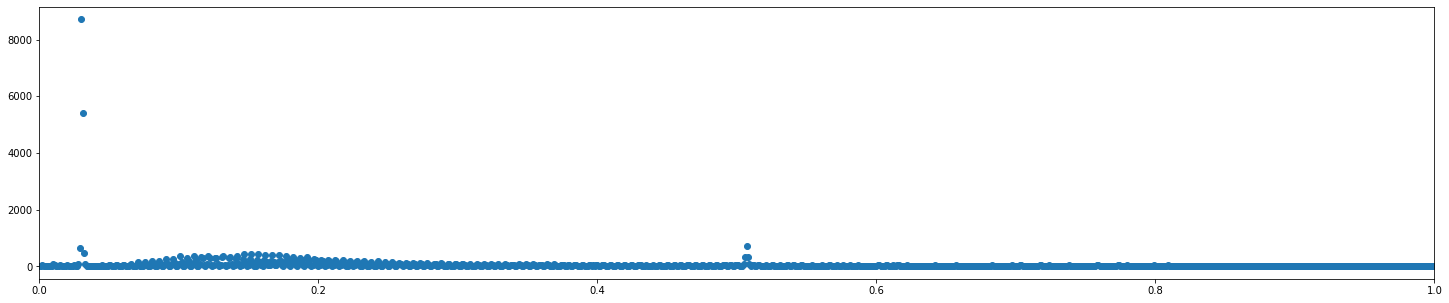

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


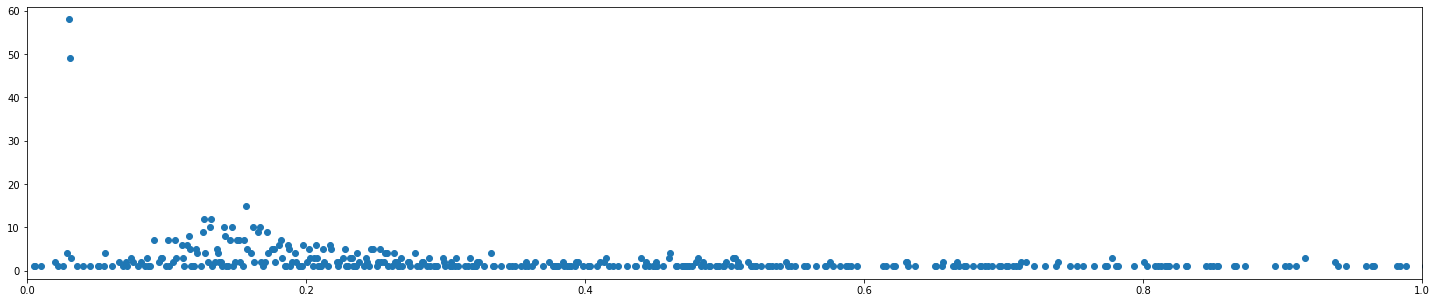

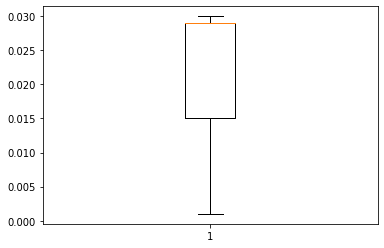

{'nobs': 77469, 'minmax': (0.001, 470.563), 'mean': 0.9530173230582556, 'variance': 23.67613574553044, 'skewness': 33.55752597591439, 'kurtosis': 1900.6953710851008, 'user': 'user20'}
user 21
absent+present


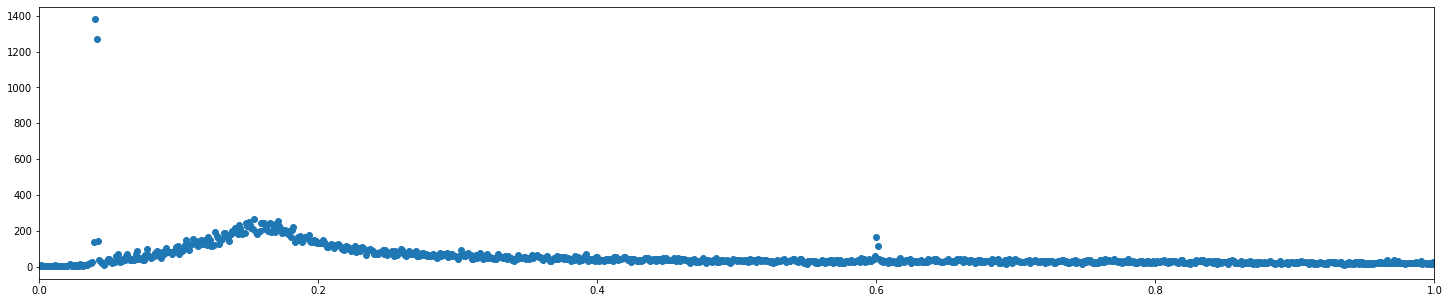

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


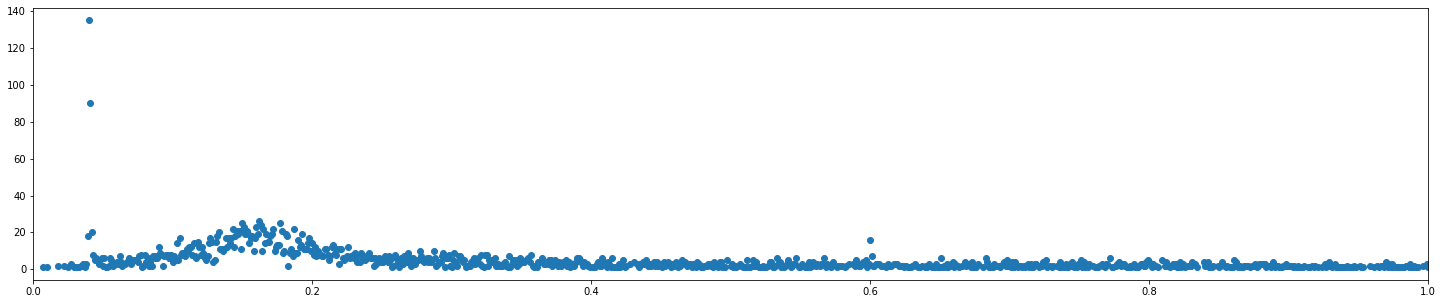

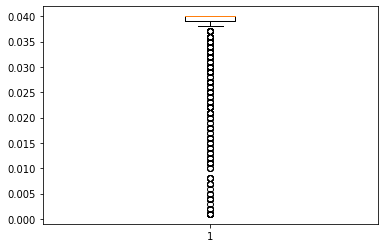

{'nobs': 75557, 'minmax': (0.001, 1960.211), 'mean': 1.3675050226980956, 'variance': 247.26668674349278, 'skewness': 83.78366262897521, 'kurtosis': 8333.874051526742, 'user': 'user21'}
user 22
absent+present


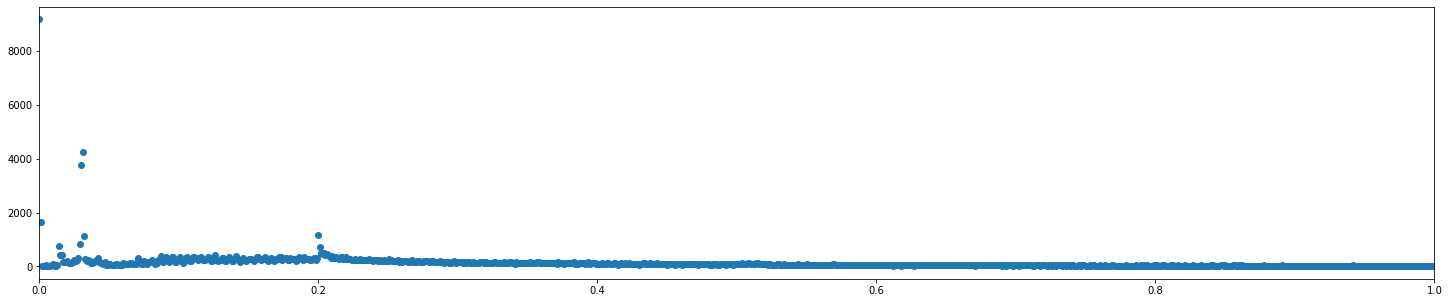

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


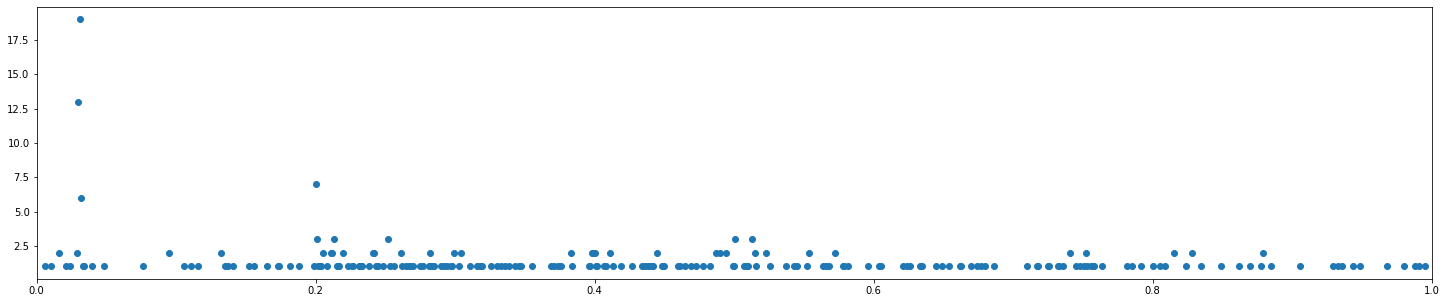

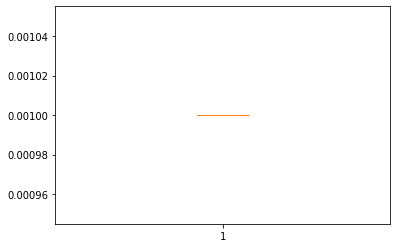

{'nobs': 140556, 'minmax': (0.001, 3195.133), 'mean': 0.7500794060730243, 'variance': 282.7498755461189, 'skewness': 144.3036537236807, 'kurtosis': 23805.10767476528, 'user': 'user22'}
user 23
absent+present


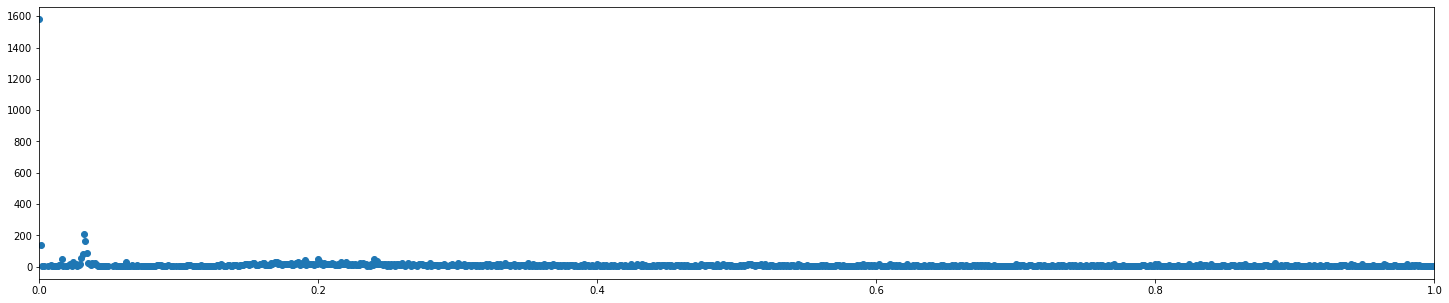

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


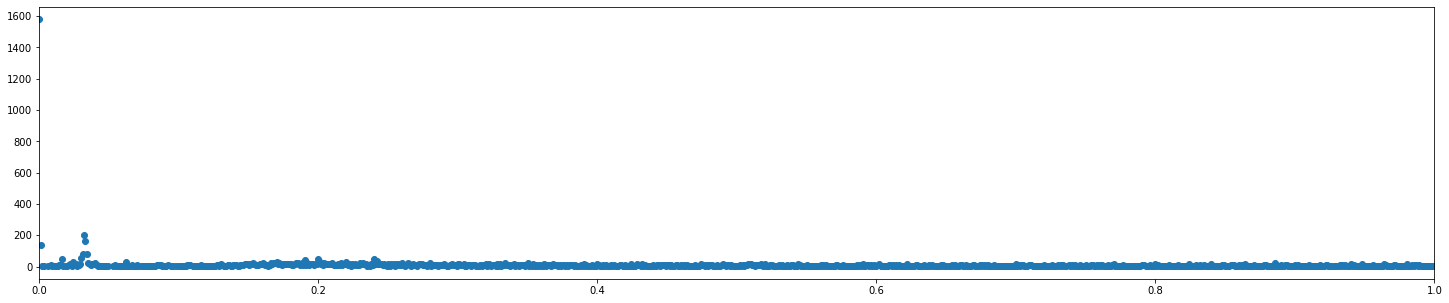

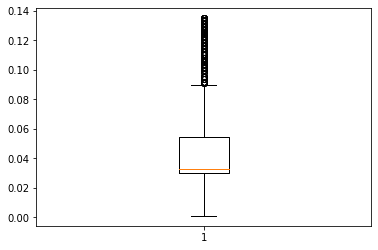

{'nobs': 15786, 'minmax': (0.001, 2988.626), 'mean': 4.80869187888002, 'variance': 3291.641209030935, 'skewness': 30.74323023373911, 'kurtosis': 1136.6203471288607, 'user': 'user23'}
user 24
absent+present


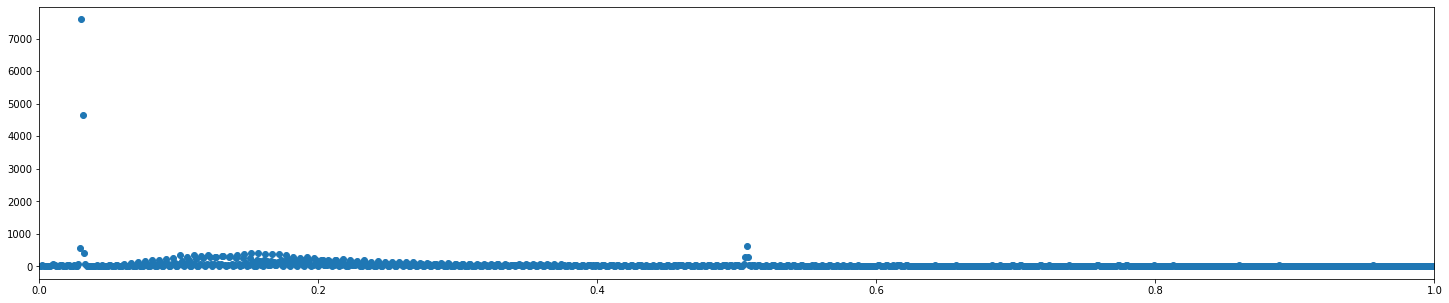

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


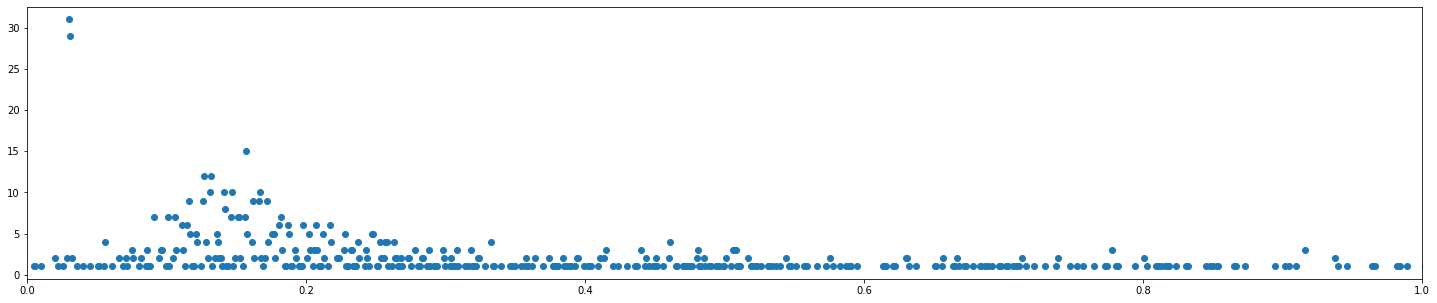

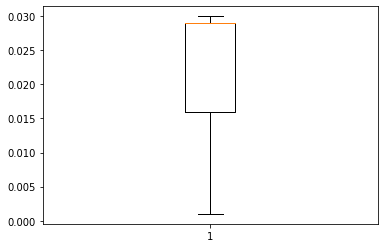

{'nobs': 70939, 'minmax': (0.001, 470.563), 'mean': 0.9497206332200906, 'variance': 23.707397936811144, 'skewness': 34.83714795738854, 'kurtosis': 2027.327847215322, 'user': 'user24'}
user 25
absent+present


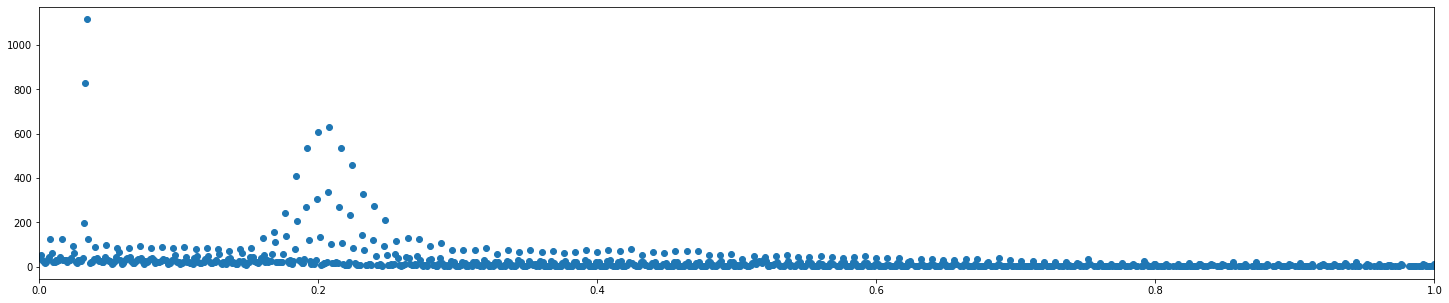

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


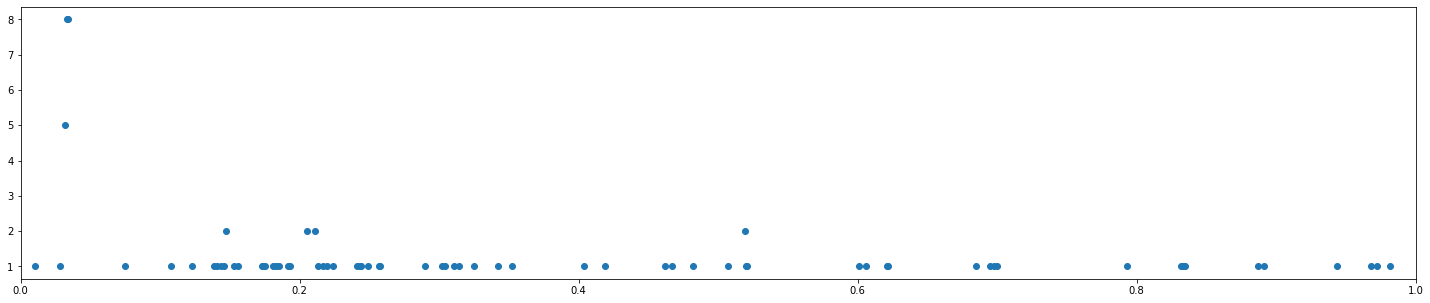

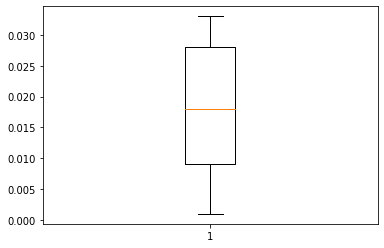

{'nobs': 26165, 'minmax': (0.001, 2528.188), 'mean': 0.9539707242499523, 'variance': 646.7786411583693, 'skewness': 72.82043222515182, 'kurtosis': 5932.358317909121, 'user': 'user25'}
user 26
absent+present


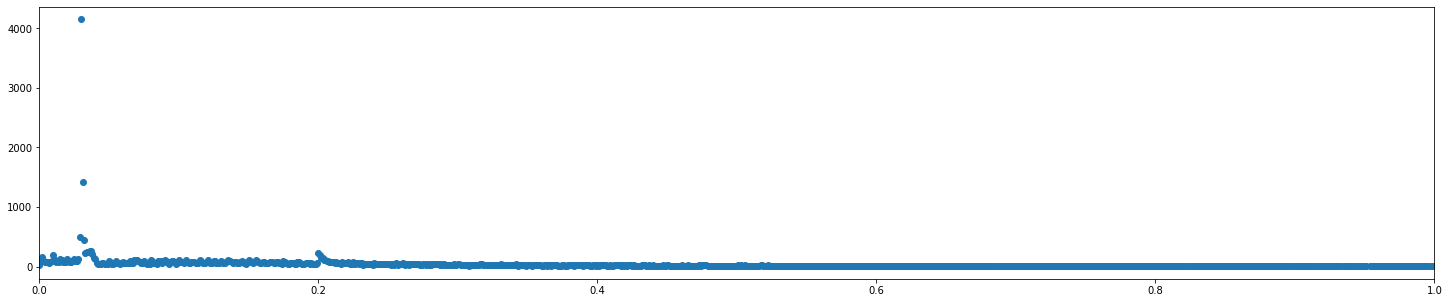

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


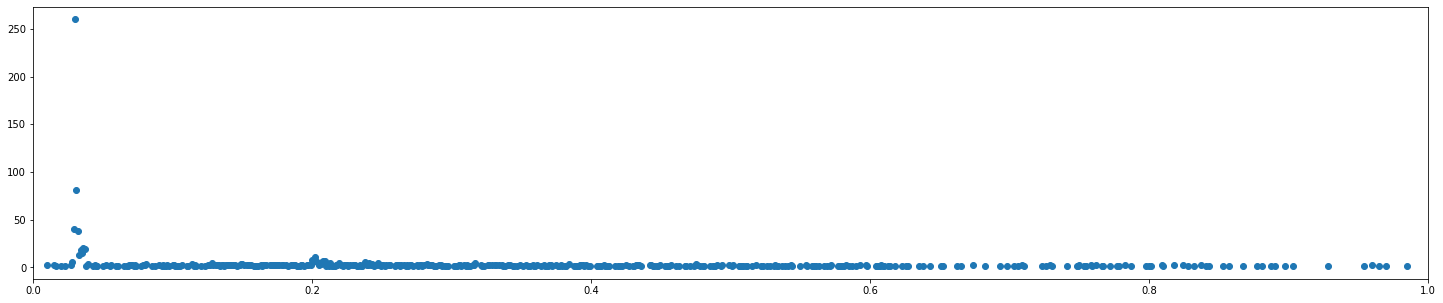

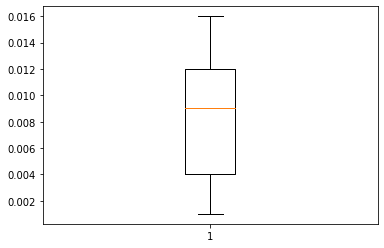

{'nobs': 35897, 'minmax': (0.001, 350.612), 'mean': 0.6879452600495863, 'variance': 31.32975924374404, 'skewness': 31.975969487998107, 'kurtosis': 1451.7532183420897, 'user': 'user26'}
user 27
absent+present


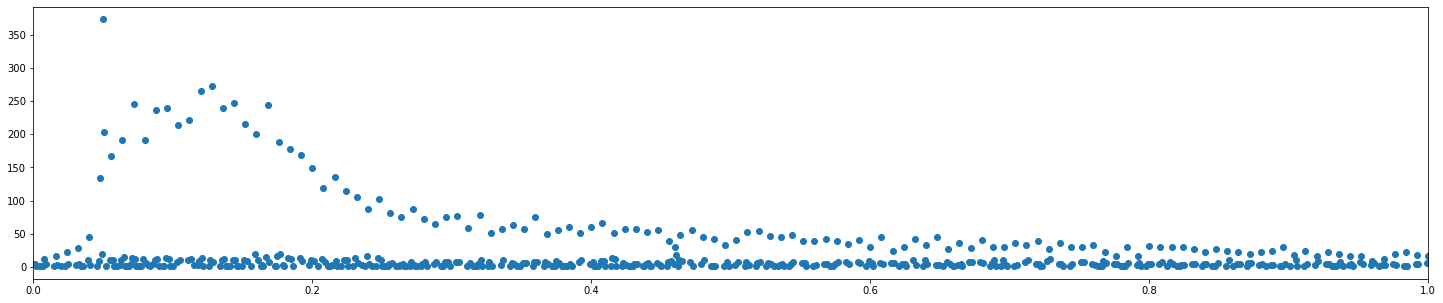

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


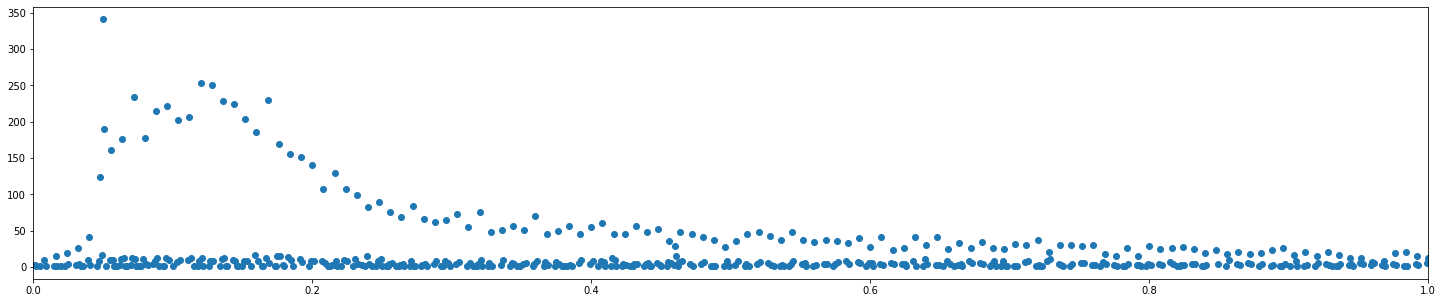

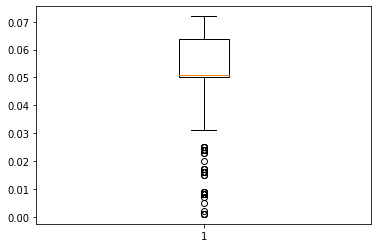

{'nobs': 13846, 'minmax': (0.001, 2783.657), 'mean': 1.3443122923588038, 'variance': 1160.5296932213544, 'skewness': 78.42635010560203, 'kurtosis': 6351.045041592752, 'user': 'user27'}
user 28
absent+present


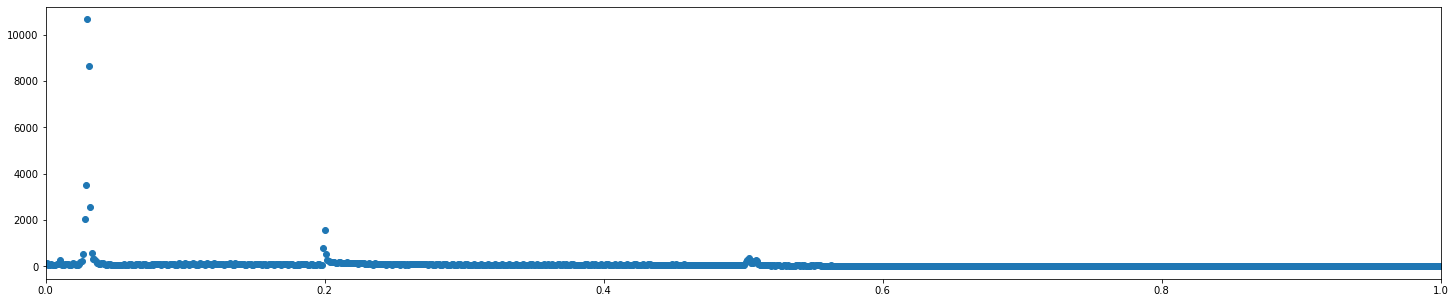

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


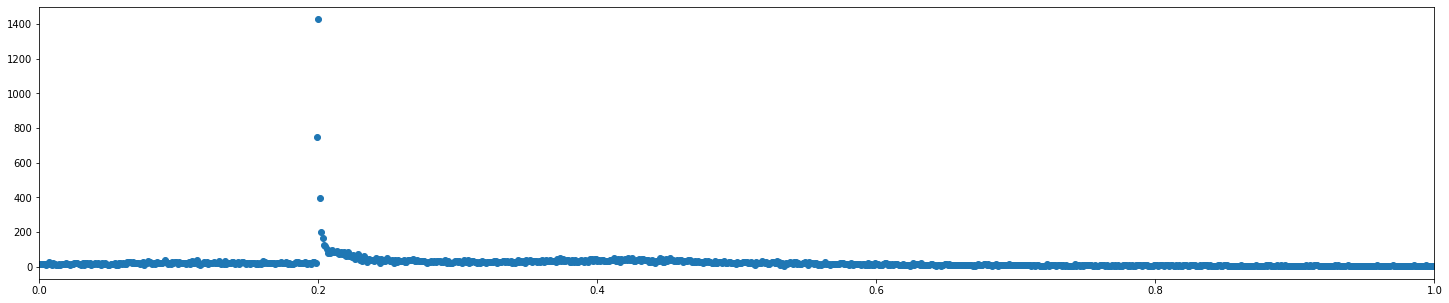

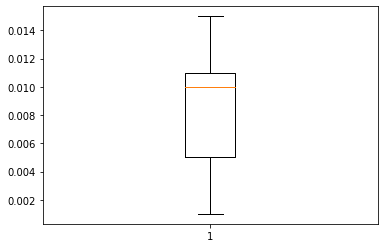

{'nobs': 94142, 'minmax': (0.001, 894.578), 'mean': 0.47618353126128615, 'variance': 15.366188460680755, 'skewness': 137.53242167365866, 'kurtosis': 29217.148733657334, 'user': 'user28'}
user 29
absent+present


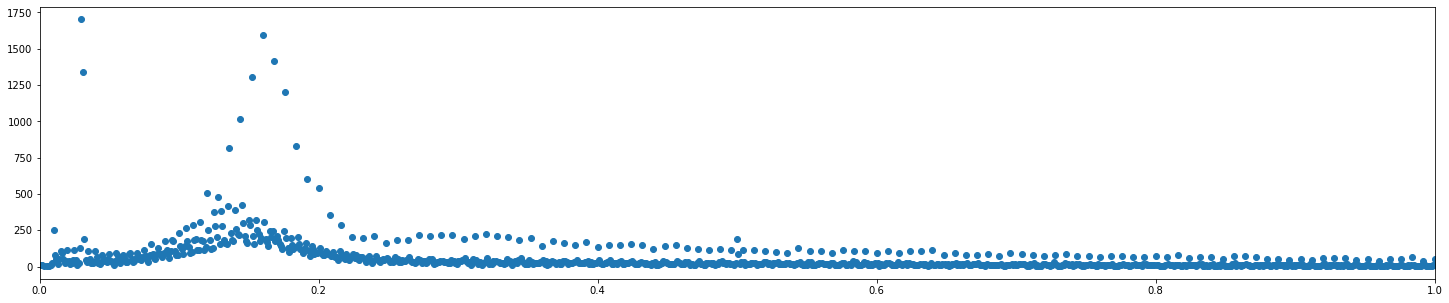

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


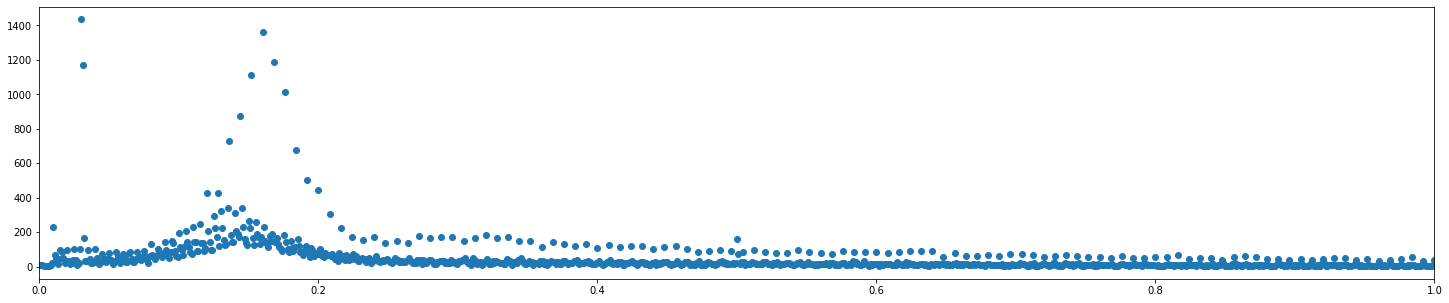

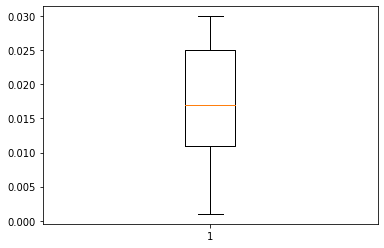

{'nobs': 73269, 'minmax': (0.001, 2675.847), 'mean': 1.509992711788069, 'variance': 585.526816125022, 'skewness': 61.07382378617207, 'kurtosis': 5080.58966840487, 'user': 'user29'}
user 30
absent+present


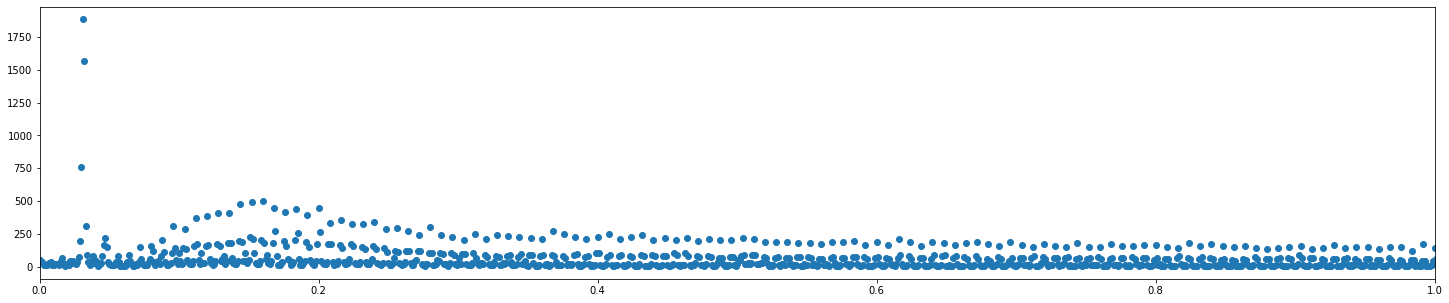

p = 0
The null hypothesis can be rejected
only present
<class 'dict_items'>


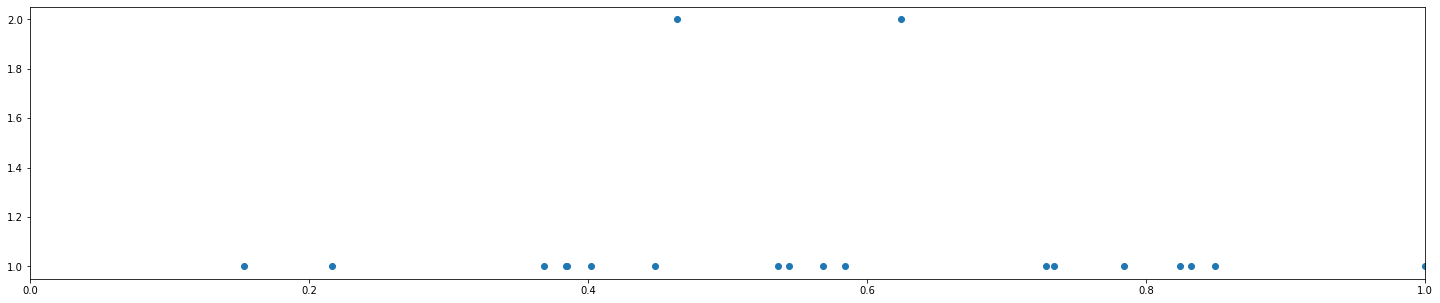

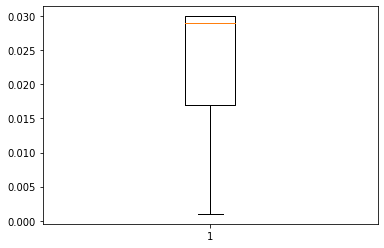

{'nobs': 101090, 'minmax': (0.001, 3512.264), 'mean': 2.069244366406173, 'variance': 1035.820572542892, 'skewness': 74.5290037644241, 'kurtosis': 6343.958523465377, 'user': 'user30'}
30


In [99]:
descriptive_statistics = []
described_format = []

for i in range(1, 31):
    print("user", i)
    print("absent+present")
    #print(time_results['user'+str(i)][0].items())
    if i == 12:
        print(time_results['user'+str(i)][0].items())
    listed_gaps = sorted(time_results['user'+str(i)][0].items())
    x, y = zip(*listed_gaps) # plotting
    ticks = x[1::2]
    plt.figure(figsize=(25, 5))
    plt.xlim([0.0, 1.0])
    plt.scatter(x, y, marker='o')
    plt.show()
    k2, p = stats.normaltest(y)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")
    print("only present")
    print(type(time_results['user'+str(i)][0].items()))
    listed_gaps = sorted(time_results['user'+str(i)][1].items())
    x2, y2 = zip(*listed_gaps) # plotting
    ticks = x[1::2]
    plt.figure(figsize=(25, 5))
    plt.xlim([0.0, 1.0])
    plt.scatter(x2, y2, marker='o')
    plt.show()
    describe_list = []
    for k, v in time_results['user'+str(i)][0].items():
        helper_list = [float(k)]*v
        describe_list.extend(helper_list)
    for_describe = sorted([item for item in describe_list if item > 0])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(for_describe[:1500])
    plt.show()
    described_format.append(for_describe)
    statistics = stats.describe(for_describe)._asdict()
    statistics["user"] = 'user'+str(i)
    print(statistics)
    descriptive_statistics.append(statistics)
print(len(described_format))

# Part 3
Compare users

In [100]:
sorted_by_mean = sorted(descriptive_statistics, key=lambda item: item['mean'])
print("SORTED BY MEAN")
for item in sorted_by_mean:
    print(item['user'], ":", item['mean'])

SORTED BY MEAN
user8 : 0.25774901046922116
user11 : 0.3897605750962773
user14 : 0.41514743657785796
user28 : 0.47618353126128615
user19 : 0.5314145674531155
user4 : 0.5863719488592377
user2 : 0.6614927097661623
user26 : 0.6879452600495863
user5 : 0.7246434497840588
user22 : 0.7500794060730243
user15 : 0.845018966644866
user1 : 0.8567961252981641
user24 : 0.9497206332200906
user20 : 0.9530173230582556
user25 : 0.9539707242499523
user3 : 0.9592256709423962
user9 : 1.1894678486191612
user7 : 1.279848480968083
user27 : 1.3443122923588038
user21 : 1.3675050226980956
user18 : 1.375902159673616
user6 : 1.3948622944693572
user12 : 1.4348532840489054
user10 : 1.4920675369045875
user29 : 1.509992711788069
user17 : 1.5719157022918084
user30 : 2.069244366406173
user13 : 2.610598556981489
user23 : 4.80869187888002
user16 : 6.767752471053374


In [101]:
sorted_by_variance = sorted(descriptive_statistics, key=lambda item: item['variance'])
print("SORTED BY VARIANCE")
for item in sorted_by_variance:
    print(item['user'], ":", item['variance'])

SORTED BY VARIANCE
user15 : 1.3664222345876746
user14 : 1.815846888982016
user2 : 2.3028699087938382
user8 : 3.3028324563552744
user28 : 15.366188460680755
user20 : 23.67613574553044
user24 : 23.707397936811144
user26 : 31.32975924374404
user5 : 34.07190215808089
user4 : 71.82577700965719
user19 : 157.94241886679603
user11 : 174.0592356149106
user17 : 179.70286725840995
user21 : 247.26668674349278
user3 : 252.20481676104023
user1 : 277.3993696807862
user22 : 282.7498755461189
user12 : 293.686901026154
user18 : 455.1556692445067
user9 : 546.4809151379114
user6 : 562.638435814999
user29 : 585.526816125022
user25 : 646.7786411583693
user7 : 663.9091864554955
user10 : 827.9603710710861
user30 : 1035.820572542892
user27 : 1160.5296932213544
user13 : 1357.490626978058
user23 : 3291.641209030935
user16 : 5776.592218761062


In [102]:
sorted_by_max = sorted(descriptive_statistics, key=lambda item: item['minmax'][1])
print("SORTED BY MAX")
for item in sorted_by_max:
    print(item['user'], ":", item['minmax'])

SORTED BY MAX
user15 : (0.001, 22.079)
user2 : (0.001, 29.498)
user14 : (0.001, 69.527)
user26 : (0.001, 350.612)
user8 : (0.001, 408.302)
user20 : (0.001, 470.563)
user24 : (0.001, 470.563)
user17 : (0.008, 818.012)
user28 : (0.001, 894.578)
user5 : (0.001, 1497.38)
user21 : (0.001, 1960.211)
user18 : (0.001, 2485.957)
user25 : (0.001, 2528.188)
user7 : (0.001, 2609.346)
user13 : (0.001, 2632.029)
user29 : (0.001, 2675.847)
user4 : (0.001, 2697.892)
user27 : (0.001, 2783.657)
user9 : (0.001, 2888.003)
user16 : (0.001, 2988.626)
user23 : (0.001, 2988.626)
user19 : (0.001, 3057.865)
user1 : (0.001, 3066.985)
user6 : (0.001, 3089.105)
user12 : (0.001, 3089.105)
user3 : (0.001, 3109.492)
user22 : (0.001, 3195.133)
user10 : (0.001, 3239.82)
user30 : (0.001, 3512.264)
user11 : (0.001, 3577.058)


In [103]:
score_repeats = 100
stats.kruskal(described_format[0][:score_repeats], described_format[2][:score_repeats], described_format[3][:score_repeats], described_format[4][:score_repeats], described_format[5][:score_repeats], described_format[6][:score_repeats], described_format[7][:score_repeats], described_format[8][:score_repeats], described_format[9][:score_repeats], described_format[10][:score_repeats], nan_policy='omit')

KruskalResult(statistic=814.6379634779581, pvalue=1.5013416104807906e-169)

In [104]:
from scipy.stats import f_oneway
print(f_oneway(described_format[0][:score_repeats], described_format[1][:score_repeats], described_format[2][:score_repeats], described_format[3][:score_repeats], described_format[4][:score_repeats], described_format[5][:score_repeats], described_format[6][:score_repeats], described_format[7][:score_repeats], described_format[8][:score_repeats], described_format[9][:score_repeats], described_format[10][:score_repeats]))

F_onewayResult(statistic=272.5976642789845, pvalue=3.376592122234102e-288)


In [105]:
test_tukey_data = []
for i in range(30):
    print (i,":",len(described_format[i][:score_repeats]))
    test_tukey_data.extend(described_format[i][:score_repeats])
df = pd.DataFrame({'score': test_tukey_data,
                   'group': np.repeat(['1', '2', '3','4', '5', '6','7', '8', '9', '10', '11', '12', '13','14', '15', '16','17', '18', '19', '20', '21', '22', '23', '24', '25','26', '27', '28', '29', '30'], repeats=score_repeats )})
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['group'],
                          alpha=0.05)
print(tukey)
print(tukey.reject)
print(len(tukey.reject))
print(len([x for x in tukey.reject if x == True]))

0 : 100
1 : 100
2 : 100
3 : 100
4 : 100
5 : 100
6 : 100
7 : 100
8 : 100
9 : 100
10 : 100
11 : 100
12 : 100
13 : 100
14 : 100
15 : 100
16 : 100
17 : 100
18 : 100
19 : 100
20 : 100
21 : 100
22 : 100
23 : 100
24 : 100
25 : 100
26 : 100
27 : 100
28 : 100
29 : 100
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1     10   0.0013    0.9  -0.002  0.0046  False
     1     11      0.0    0.9 -0.0033  0.0033  False
     1     12   0.0073  0.001   0.004  0.0106   True
     1     13   0.0084  0.001  0.0051  0.0117   True
     1     14   0.0123  0.001   0.009  0.0156   True
     1     15   0.0454  0.001  0.0421  0.0487   True
     1     16      0.0    0.9 -0.0033  0.0033  False
     1     17   0.0288  0.001  0.0254  0.0321   True
     1     18   0.0108  0.001  0.0075  0.0141   True
     1     19      0.0    0.9 -0.0033  0.0033  False
     1      2   0.0409  0.001  0.0376  0.0442   Tru

final
7.3
{'0': 2.605, '1': 2.383, '2': 2.935, '3': 1.912, '4': 2.333, '5': 3.663, '6': 2.748, '7': 0.76, '8': 2.454, '9': 3.272, '10': 0.565, '11': 4.158, '12': 4.063, '13': 1.308, '14': 2.68, '15': 7.3, '16': 4.291, '17': 2.773, '18': 0.92, '19': 3.046, '20': 3.678, '21': 2.005, '22': 6.861, '23': 3.046, '24': 1.473, '25': 1.507, '26': 2.375, '27': 1.214, '28': 2.376, '29': 4.139}


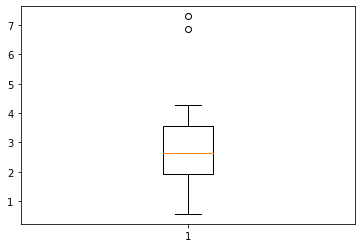

In [108]:
import math

maximum = 0
maxes = {}
for i in range(30):
    maxes[str(i)] = 0
    for j in range( math.ceil(len(described_format[i]) * 0.95) ):
        if maximum < described_format[i][j]:
            maximum = described_format[i][j]
        if maxes[str(i)] < described_format[i][j]:
            maxes[str(i)] = described_format[i][j]
print("final")
print(maximum)
print(maxes)

maxes_list = list(maxes.values())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(maxes_list)
plt.show()